# 机器学习 HW2
各位同学好，在这个notebook中，我们会带领大家逐步实现一个图像分类任务，一共包含以下几个主要部分：
1. **数据集**：加载训练和测试使用的animal10数据集
2. **模型**：构建实验所需要的ResNet34神经网络
3. **训练和测试**：构建模型训练和测试的整个pipeline

其中每一部分会涉及到一些代码填空题，需要大家根据提示补充相应的代码后才能继续执行后续代码块。如果对如何使用pytorch实现图像分类不熟悉的话，建议大家仔细回顾我们在第一次作业中为大家提供的[**实例代码**](https://www.kaggle.com/code/guluguluwulu/pytorch-logistic-regression)，相信会对大家完成本次作业有帮助。

## 导入必要的库

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision.transforms import v2
# PyTorch 2.0 之后的版本建议使用 torchvision.transforms.v2 来代替 torchvision.transforms
from torch.utils.data import Dataset, DataLoader
import glob 
import random
from PIL import Image
from tqdm import tqdm
from collections import defaultdict

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

## 固定随机数种子（**必须执行该代码块！**）

In [2]:
# 设置随机数种子，保证每个人的训练集、验证集和测试集都相同
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(2024)

## GPU设置
1. 本次作业需要使用 GPU 对模型进行加速。请搭建先右边栏的 “ACCELERATOR” 选项设置为 **GPU T4×2**。

2. 由于 Kaggle 对 GPU 的使用有一定的时间限制 (每周20卡时)，所以当你只想使用 CPU 对程序进行调试时，可以将 “ACCELERATOR” 选项设置为 **None**。
<div style="text-align:center;">
    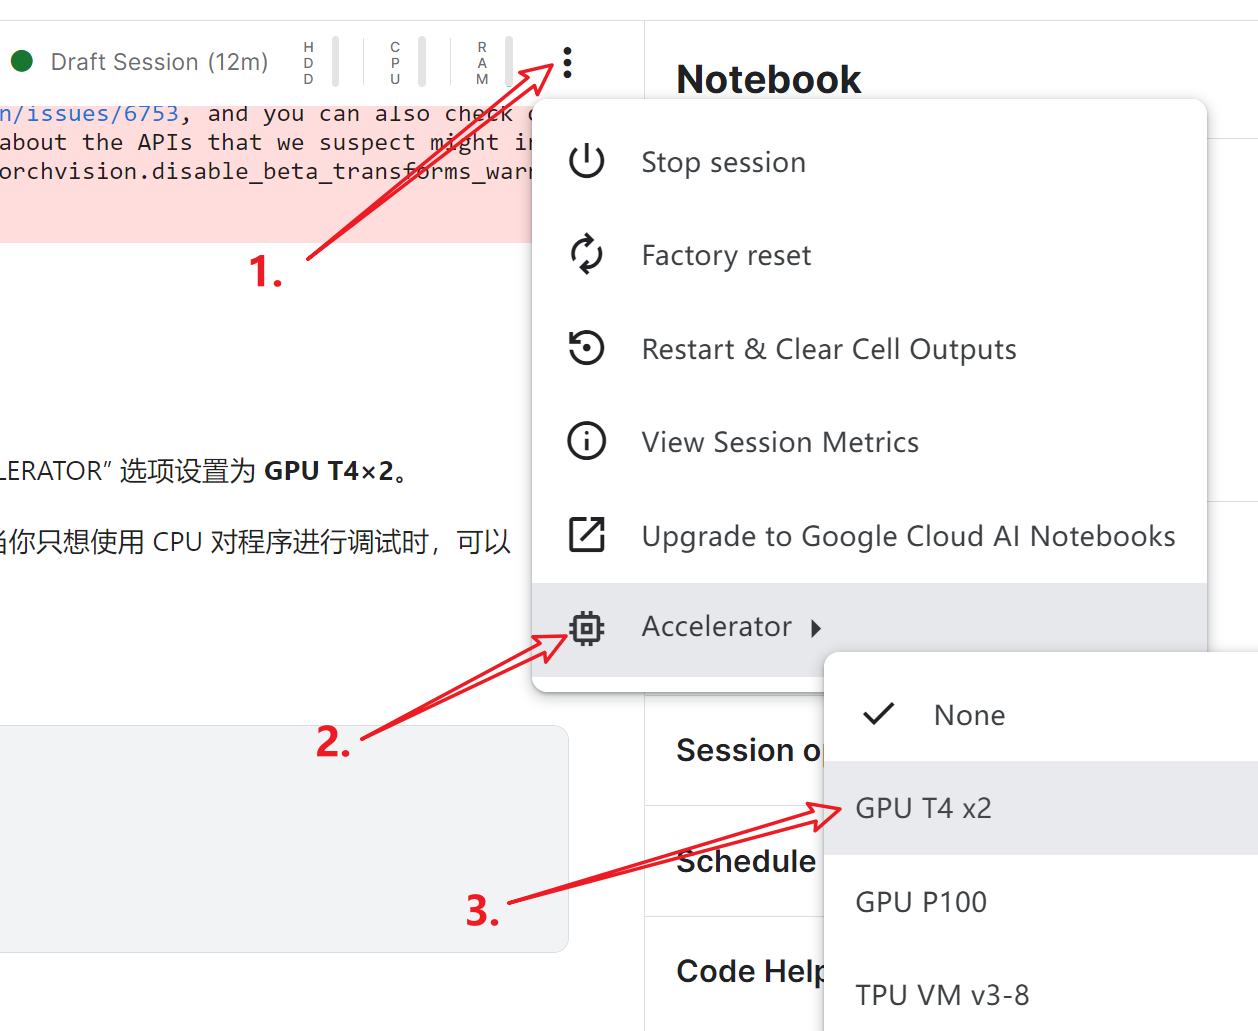
</div>

In [3]:
print(torch.__version__)
# 检查GPU是否可用，并检查是否正确选择了GPU类型
# 在使用 cpu 环境对程序进行调试的时候可以先注释掉这2行代码
assert torch.cuda.is_available(), "Please select GPU accelerator"
assert torch.cuda.device_count() == 2, "Please select accelerator as 'T4 x 2'"
# 检查是否按要求设定了随机数种子
assert torch.initial_seed() == 2024, "Please set your random seed first!"

2.0.0


In [4]:
ngpu = torch.cuda.device_count()  # 可用的 GPU 数量. 0 表示使用 CPU.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


## 加载 Animals-10 数据集

该数据集包含约 2.8 万张动物图像，共属于 10 个类别，包括狗、猫、马、蜘蛛、蝴蝶、鸡、羊、牛、松鼠、大象等。为模拟真实情况，数据集中可能存在一些错误数据。

### 加载数据

In [5]:
# 原来的数据目录名称为意大利语，这里转换为英语
classes_dict = { 
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
    "ragno": "spider",
    "scoiattolo": "squirrel",
}

classes = ["dog", "horse", "elephant", "butterfly", "chicken", "cat", "cow", "sheep", "spider", "squirrel",]

data = {
    "path":[],
    "label":[]
}

data_dir="/kaggle/input/animals10/raw-img"

### 数据集样本展示

分别使用 pandas 库和 matplotlib 库来展示部分的数据。

In [6]:
for label_it, label_en in classes_dict.items():
    paths = glob.glob(f'{data_dir}/{label_it}/*.jpeg')

    data["path"].extend(paths)
    data["label"].extend([label_en] * len(paths))

df_data = pd.DataFrame(data)
df_data.head()

,path,label
0,/kaggle/input/animals10/raw-img/cane/OIP-6p-HH...,dog
1,/kaggle/input/animals10/raw-img/cane/OIP-A1GkR...,dog
2,/kaggle/input/animals10/raw-img/cane/OIP-GZmwq...,dog
3,/kaggle/input/animals10/raw-img/cane/OIP-Yj0uE...,dog
4,/kaggle/input/animals10/raw-img/cane/OIP-bbrbp...,dog


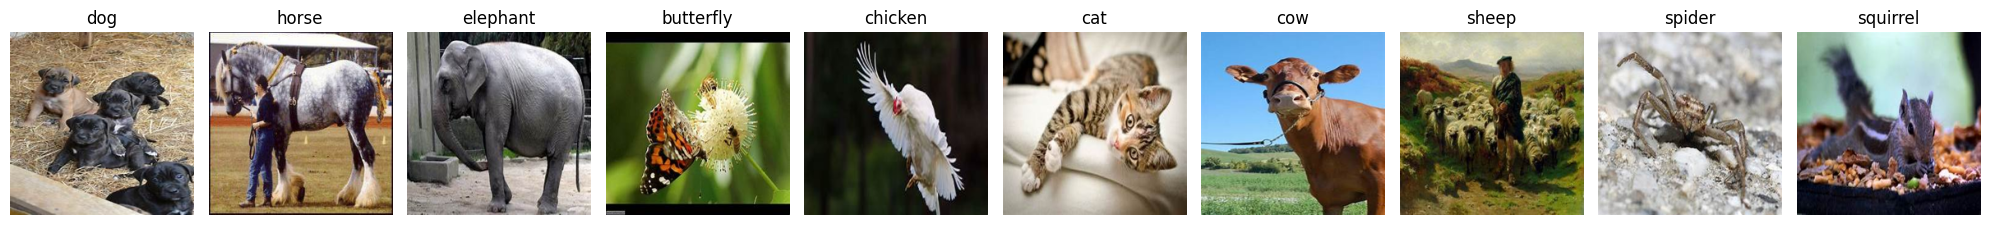

In [7]:
plt.figure(figsize = (20, 7))

for idx, i in enumerate(df_data.label.unique()):
    plt.subplot(1, 10, idx + 1)
    df = df_data[df_data['label'] == i].reset_index(drop=True)
    
    image_path = df.loc[random.randint(0, len(df) - 1), 'path']
    img = Image.open(image_path)
    img = img.resize((224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    
plt.tight_layout()
plt.show()

### 使用 Pytorch 加载数据集

#### **数据增强（Data Augmentation）**

在深度学习中，要求样本数量充足，样本数量越多，训练出来的模型效果越好，模型的泛化能力越强。但是实际中，样本数量不足或者样本质量不够好，这时就需要对样本做数据增强，即通过一定的方式改变输入数据，以生成更多样的训练样本，从而提高模型的泛化能力和效果。数据增强可以减少模型对某些特征的过度依赖，从而避免过拟合。

例如在图像分类任务中，对于输入的图像可以进行一些简单的平移、缩放、颜色变换等操作，这些操作不会改变图像的类别，但可以增加训练样本的数量。这些增强后的样本可以帮助模型更好地学习和理解图像的特征，提高模型的泛化能力和准确率。

### 任务 1（10 Points）
请在下方代码的空白处添加一些数据增强函数，并在后面“测试 transform 效果”的代码块输出5张不同样式的数据增强后的图片。<br>
**数据增强后的图片需要保证长宽均为224，通道数为3。**

PyTorch 官方提供了一些包装好的数据增强 api。具体可参考 https://pytorch.org/vision/stable/transforms.html

In [8]:
"""
测试时使用的数据增强：
在测试时，test_tfm 可以不使用 data augmentation，
但也有一种手段叫做 test time augmentation (TTA)，
感兴趣的同学可以自行去了解并实现，这里不做要求
"""
test_tfm = v2.Compose([
    v2.Resize((224,224)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

"""
训练时使用的数据增强：
请大家补充合适的数据增强方法，需要注意的是不同增强手段会对模型最终的准确率有影响
大家可以通过调试找出合适的数据增强方式
"""
train_tfm = v2.Compose([
    v2.Resize((224,224)),
    
    # =========== 请在此处自行补充一些数据增强方式 ===========
    v2.RandomVerticalFlip(p=0.5),  #随机垂直翻转，以50%的概率进行
    v2.RandomHorizontalFlip(p=0.5), # 随机水平翻转
    v2.RandomRotation(degrees=(0, 360)), #随机旋转，角度范围在0到360度之间。
    #随机颜色变换，包括亮度、对比度、饱和度和色相的随机变化。
    v2.ColorJitter(brightness=.3, contrast=.3,saturation=.3,hue=.2), 
    #v2.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10), #随机仿射变换，包括随机旋转、平移、缩放和剪切。
    #v2.RandomErasing(p=0.5, scale=(0.02, 0.2)), #随机擦除，以一定的概率随机擦除图像的一部分。
    #v2.Grayscale(),
    v2.AutoAugment(),  # 使用 AutoAugment
    # ===================================================

    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


#### **数据集 (Dataset)**

PyTorch 提供了 ```torch.utils.data.Dataset``` 类来定义数据集。用户可以继承该类从而实现自定义数据集。自定义的数据集一般需要实现以下3个类方法：
+ ```__init__``` 进行数据集的初始化
+ ```__len__``` 返回数据集包含的数据数量
+ ```__getitem__``` 根据索引从数据集中获取对应的数据

### 任务 2（10 Points）
请对数据集的 ```__getitem__``` 函数进行补充，使程序能正常运行。

In [9]:
# 定义 AnimalDataset 数据集
class AnimalDataset(Dataset):
    
    def __init__(self, path_lst, label_lst, tfm):
        super(AnimalDataset).__init__()
        self.path_lst = path_lst
        self.label_lst = label_lst
        self.transform = tfm

    def __len__(self):
        return len(self.path_lst)

    def __getitem__(self, idx):
        
        """
        以下是一段空缺的代码，你需要对 AnimalDataset 类的 __getitem__ 函数进行补充。
        目标：
          根据参数 idx(数据的索引) 从数据集的 path_lst 和 label_lst 中取出对应的图片路径 fname 和标签 label
        """
        # ========== 请在此处补充你的代码 ==========
        fname = self.path_lst[idx]
        label = self.label_lst[idx]
        
        
        # =======================================
        
        img = Image.open(fname)
        img = self.transform(img)
        
        return img, label

以下函数用于将数据集划分为训练集、验证集和测试集。这个函数无需进行修改。

**注意：如果你修改了任务1和任务2的代码，那么再次运行以下函数将无法得到新的结果。函数会返回其第一次执行的结果。因此如果你需要修改前面的代码，在修改后，请点击右上角的重启环境按钮，再重新执行所有的代码块。**

In [10]:
def get_datasets(data_dir, sample_ratio=0.25, split_ratio=[0.7, 0.1, 0.2]):
    """
    按照一定比例（7:1:2），手动将数据集划分为训练集、验证集和测试集。
    由于之前设定了随机数种子，因此每位同学得到的训练集、验证集和测试集都是一样的。这个函数无需进行修改。
    """
    assert sum(split_ratio) == 1.0
    global train_dataset, val_dataset, test_dataset
    try:  # 保证函数多次执行时结果不变
        if train_dataset is not None:
            print("datasets exist!")
            return train_dataset, val_dataset, test_dataset
    except NameError:
        pass
    
    data_all = defaultdict(list)
    for i, (label_it, label_en) in enumerate(classes_dict.items()):
        paths = glob.glob(f'{data_dir}/{label_it}/*.jpeg')
        data_all["path"].extend(paths)
        data_all["label"].extend([i] * len(paths))
    n_data_all = len(data_all["path"])
    # 下面的代码首先生成了一个从 0 到 n_data_all 的乱序的全排列，随后再取前 k 个数值。
    # 这是一种很方便和快速的随机采样方法。
    rp = torch.randperm(n_data_all)
    n_sampled_data = int(n_data_all * sample_ratio)
    n_train_data = int(n_sampled_data * split_ratio[0])
    n_val_data = int(n_sampled_data * split_ratio[1])
    n_test_data = n_sampled_data - n_train_data - n_val_data
    print("number of training image:", n_train_data)
    print("number of validation image:", n_val_data)
    print("number of testing image:", n_test_data)
    
    path_lsts = [[], [], []]
    label_lsts = [[], [], []]
    
    for i, k in enumerate(rp):
        idx = k.item()
        if i >= n_sampled_data:
            break
        if i < n_train_data:
            path_lsts[0].append(data_all["path"][idx])
            label_lsts[0].append(data_all["label"][idx])
        elif i < n_train_data + n_val_data:
            path_lsts[1].append(data_all["path"][idx])
            label_lsts[1].append(data_all["label"][idx])
        else:
            path_lsts[2].append(data_all["path"][idx])
            label_lsts[2].append(data_all["label"][idx])
    
    train_dataset = AnimalDataset(path_lsts[0], label_lsts[0], tfm=train_tfm)
    val_dataset = AnimalDataset(path_lsts[1], label_lsts[1], tfm=test_tfm)
    test_dataset = AnimalDataset(path_lsts[2], label_lsts[2], tfm=test_tfm)
    
    return train_dataset, val_dataset, test_dataset

    
train_dataset, val_dataset, test_dataset = get_datasets(data_dir="/kaggle/input/animals10/raw-img")

number of training image: 4236
number of validation image: 605
number of testing image: 1211


### 测试代码1： 对`__getitem__`函数进行测试
**以下代码用于验证 \_\_getitem\_\_ 函数以及数据增强后输出tensor的形状，通过该部分测试可以得到任务2中对应的分数**

In [11]:
correct_labels = train_dataset.label_lst[:50]
your_labels = [train_dataset[_][1] for _ in range(50)]

if your_labels == correct_labels:
    print("__getitem__ 函数验证正确！")
else:
    print("__getitem__ 函数验证错误！")

print("")
    
img = train_dataset[0][0]
if img.size() == torch.Size([3, 224, 224]):
    print("数据增强输出形状正确！")
else:
    print("数据增强输出形状错误！")

__getitem__ 函数验证正确！

数据增强输出形状正确！


### 测试代码2： 对`train_tfm`数据增强效果进行测试
**以下代码用于验证 train_tfm 数据增强的效果，通过该部分测试可以得到任务1中对应的分数**。

要求：下面代码展示出的5张图片都是经过数据增强转换过的

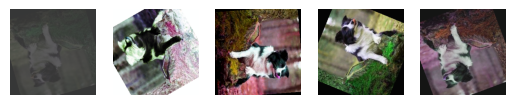

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 5)

for i in range(5):
    img, label = train_dataset[7]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    unnormalized_img = img.cpu().numpy().transpose((1, 2, 0)) * std + mean
    # print(unnormalized_img)

    # 确保像素值在合适范围内
    unnormalized_img = np.clip(unnormalized_img, 0, 1)

    # 显示图像
    ax[i].imshow(unnormalized_img)
    ax[i].axis('off')

fig.show()

#### **定义 DataLoader**

DataLoader 根据一定的 batch size 从数据集中取出批量化的数据，并将其逐份输入到模型中。这里直接采用 Pytorch 封装好的类 ```torch.utils.data.DataLoader```。

In [13]:
# 针对 3 个数据集生成 3 个 dataloader
batch_size = 32  # batch size 可以自行调整, 它的值可能也对模型的准确率产生影响
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## 构造 ResNet34 模型
### ResNet 介绍

ResNet 即残差网络，它由何恺明、张祥雨、任少卿和孙剑在 2015 年的论文《**[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)**》中首次提出，并可在多种任务中作为骨干网络进行特征提取。它通过跳跃连接的方式较好地解决了梯度消失问题，使得人们得以训练超过150层的深度神经网络。

卷积神经网络有一个主要缺点：梯度消失问题，即在反向传播过程中，梯度值会显著减小，这使得网络权重几乎没有变化。ResNet 使用了**跳跃连接**的方法来解决该问题。跳跃连接即打通一条直接跳过神经网络某一层的数据连接通道，将输入数据和网络的输出直接相加。

### ResNet 网络结构

常用的 ResNet 结构包括 ResNet-18、ResNet-34、ResNet-50、ResNet-101 和 ResNet-152，每种结构都有着不同的残差块结构和不同数量的残差块，如下图所示。

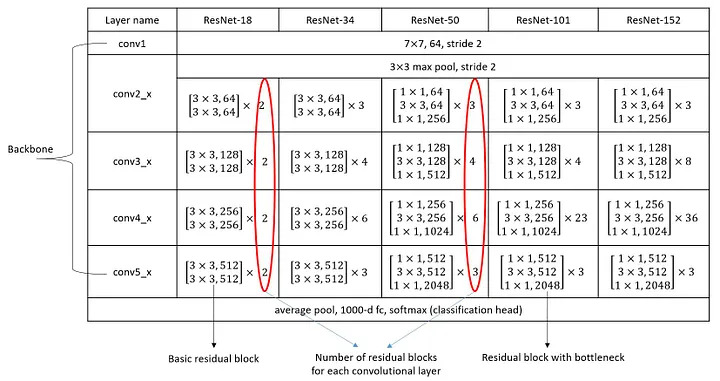

每种 ResNet 架构都由 5 个卷积层（conv1、conv2_x — conv5_x）、1 个平均池化层、1 个全连接层和 1 个 softmax 层组成。 其中的五个卷积层是骨干网络，用于提取图像特征，后面的层被用于图像分类任务。

在 ImageNet 数据集上预训练的 ResNet 骨干网络被广泛用于提取不同分辨率级别的特征（即经过 conv2_x、conv3_x、conv4_x 和 conv5_x 之后的特征图）。 这些特征之后会通过特定的网络，并针对特定任务进行微调，例如图像分类、目标检测、语义分割等。

五种 ResNet 架构使用残差块作为基本块。 从 conv2_x 到 conv5_x，每个复合卷积层会使用不同数量的残差块。如上图中红色椭圆圈起来的地方所示，ResNet-18 中 conv2_x、conv3_x、conv4_x 和 conv5_x 使用的残差块的数量分别为 2、2、2 和 2。而在 ResNet-50 中，conv2_x、conv3_x、conv4_x 和 conv5_x 使用的残差块的数量分别为 3、4、6 和 3。

ResNet-18 和 ResNet-34 使用的残差块与 ResNet-50、ResNet-101 和 ResNet-152 使用的残差块的结构有所不同，从 ResNet-50 开始，网络采用了瓶颈结构，通过交替 1x1 和 3x3 卷积来减少模型参数。 如下所示，与使用 (3x3,64) 和 (3x3,256) 两种卷积相比，模型参数量从 294912 减少为 69632。瓶颈结构的另一个优点是，更多的卷积引入了更多的激活函数。因此，模型的非线性特性和兼容性得以增加。

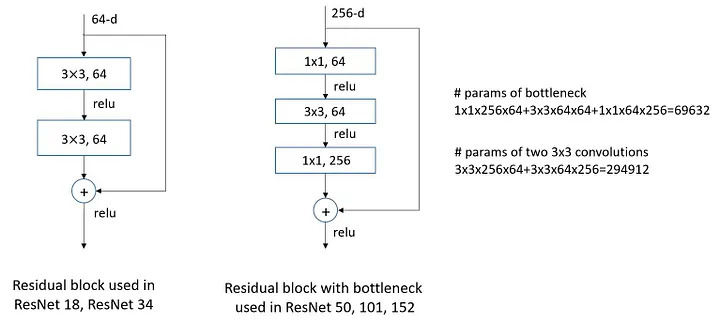

ResNet 从 conv2_x 到 conv5_x 提取了分辨率越来越低的特征。值得注意的是，conv3_x、conv4_x 和 conv5_x 层里的第一个残差块的第一个 3x3 卷积的步距为 2，这是为了对特征图进行下采样，以获得更大的感受野。因此，需要特别注意这些改变分辨率的残差块，注意输入和输出特征图的通道数和分辨率，据此调整跳跃连接的执行。

下图分别展示了在 ResNet 18、34 以及 ResNet 50、101、152 的 conv3_x 层的第一个残差块中，跳跃连接通道使用了一个步距为 2 的 1x1 卷积，以匹配输入和输出的特征图的空间维度以及通道数的差异。

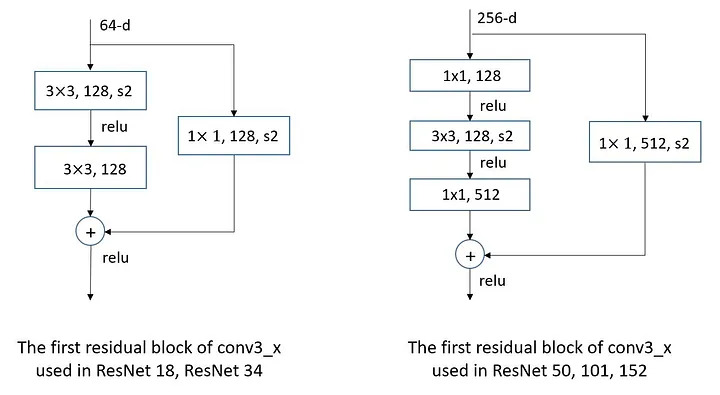

**在本次实验中，我们将定义一个 ResNet-34 网络用于 animals-10 数据集的分类。**

若你想查看别人实现的 ResNet 代码，可以自行阅读一些 github 上面成熟的开源项目或框架，如：

**torchvision** (https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py)

**detectron2** (https://github.com/facebookresearch/detectron2/blob/main/detectron2/modeling/backbone/resnet.py)

### PyTorch 模型定义

PyTorch 通过继承 ```Module``` 类来构造模型。```Module``` 类是 ```nn``` 模块里提供的一个模型构造类，是所有神经网络模块的基类，我们可以继承它来定义我们想要的模型。自定义的模型类会重载 ```Module``` 类的 ```__init__``` 函数和 ```forward``` 函数。它们分别用于创建模型参数和定义前向计算。前向计算即为正向传播。

类中无须定义反向传播函数。系统将通过自动求梯度而自动生成反向传播所需的 ```backward``` 函数。

若想更加详细地了解 PyTorch 框架是如何定义模型的，可以参考以下资料：


1. [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)
2. [《动手学深度学习（PyTorch 版）》](https://github.com/ShusenTang/Dive-into-DL-PyTorch/blob/master/docs/chapter04_DL_computation/4.1_model-construction.md)


#### **残差块**

在开始定义 ResNet 之前，我们需要先定义一个可以在整个网络中重复使用的 ```ResidualBlock``` 模块。 该模块（**如上图左边的架构所示**）包含一个跳跃连接。残差块包含一个的可选参数（```downsample```）。

### 任务 3（10 Points）
请对 ```ResidualBlock``` 的 ```forward``` 函数进行补充。

In [14]:
class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        """
        定义残差块。
        在 ResNet-18 和 ResNet-34 中，每个残差块包含 2 个 3*3 卷积。
        """
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        """
        残差块的前向传播函数。输入 x 会通过 2 层卷积，得到的输出会与原输入进行残差求和。
        """
        
        """
        以下是一段空缺的代码，你需要对残差块类的 forward 函数进行补充。
        目标：
          1. 将输入 x 用变量 residual 存储起来，防止输入丢失
          2. 将输入 x 分别通过 2 层卷积层，得到输出 out
          3. 将经过卷积层的输出 out 与输入 residual 相加得到新的 out
          注意：如果 self.downsample 不为空，则需要在相加前将输入先用 self.downsample 函数处理residual。
               别忘了在合适的地方使用类里面已经初始化好的ReLU激活函数对输出进行非线性化处理。
          提示：大家可以参考上面给出的residual block的示意图来完成前向过程
        """
        # ========== 请在此处补充你的代码 ==========
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        # =======================================
        
        return out
"""  
class ResidualBlock_50(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        
        super(ResidualBlock_50, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv3 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size = 1, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels * self.expansion
        
    def forward(self, x):
        
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        
        return out
"""

'  \nclass ResidualBlock_50(nn.Module):\n    expansion = 4\n    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):\n        \n        super(ResidualBlock_50, self).__init__()\n        self.conv1 = nn.Sequential(\n                        nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride, padding = 1),\n                        nn.BatchNorm2d(out_channels),\n                        nn.ReLU())\n        self.conv2 = nn.Sequential(\n                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),\n                        nn.BatchNorm2d(out_channels),\n                        nn.ReLU())\n        self.conv3 = nn.Sequential(\n                        nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size = 1, stride = 1, padding = 1),\n                        nn.BatchNorm2d(out_channels))\n        self.downsample = downsample\n        self.relu = nn.ReLU()\n        self.out_channels = out_channels 

### 测试代码3： 对`ResidualBlock.forward`进行测试
**以下代码用于验证 forward 函数的输出形状是否符合要求（仅验证了tensor的形状！）**

In [15]:
import copy

in_channels = [64, 64, 128, 128, 256, 256, 512]
out_channels = [64, 128, 128, 256, 256, 512, 512]
strides = [1, 2, 1, 2, 1, 2, 1]
downsamples = []
for i in range(len(strides)):
    if strides[i] != 1:
        downsample = nn.Sequential(
            nn.Conv2d(in_channels[i], out_channels[i], kernel_size=1, stride=strides[i]),
            nn.BatchNorm2d(out_channels[i]),
        )
        downsamples.append(copy.deepcopy(downsample))
    else:
        downsamples.append(None)

your_rbs = [ResidualBlock(in_channels[i], out_channels[i], strides[i], downsamples[i]) for i in range(len(strides))]

tensor_sizes = [
    (1, 64, 56, 56),
    (1, 64, 56, 56),
    (1, 128, 28, 28),
    (1, 128, 28, 28),
    (1, 256, 14, 14),
    (1, 256, 14, 14),
    (1, 512, 7, 7),
    (1, 512, 7, 7),
]

print("【以下测试用例用于检验tensor的形状，不保证值正确】")
for i in range(len(strides)):
    print(f"以下是第{i+1}个测试用例，输入形状为{tensor_sizes[i]}，期望输出形状为{tensor_sizes[i+1]}")
    x = torch.randn(tensor_sizes[i])
    x_out = your_rbs[i](x)
    if x_out.shape == torch.Size(tensor_sizes[i+1]):
        print(f"第{i+1}个测试用例通过！")
    else:
        tup = tuple(torch.tensor(x_out.shape).detach().cpu().tolist())
        print(f"第{i+1}个测试用例未通过！你的输出tensor形状为{tup}")
    
del in_channels, out_channels, strides, downsamples, your_rbs, tensor_sizes

【以下测试用例用于检验tensor的形状，不保证值正确】
以下是第1个测试用例，输入形状为(1, 64, 56, 56)，期望输出形状为(1, 64, 56, 56)
第1个测试用例通过！
以下是第2个测试用例，输入形状为(1, 64, 56, 56)，期望输出形状为(1, 128, 28, 28)
第2个测试用例通过！
以下是第3个测试用例，输入形状为(1, 128, 28, 28)，期望输出形状为(1, 128, 28, 28)
第3个测试用例通过！
以下是第4个测试用例，输入形状为(1, 128, 28, 28)，期望输出形状为(1, 256, 14, 14)
第4个测试用例通过！
以下是第5个测试用例，输入形状为(1, 256, 14, 14)，期望输出形状为(1, 256, 14, 14)
第5个测试用例通过！
以下是第6个测试用例，输入形状为(1, 256, 14, 14)，期望输出形状为(1, 512, 7, 7)
第6个测试用例通过！
以下是第7个测试用例，输入形状为(1, 512, 7, 7)，期望输出形状为(1, 512, 7, 7)
第7个测试用例通过！


#### **ResNet 网络**

接下来我们将定义 ResNet 网络。

ResNet-34 中有 4 个卷积模块，分别包含了 3个、4个、6个 和 3个 残差块。这里创建了一个辅助函数 ```_make_layer``` 来定义每一个模块。在卷积层的后面，我们添加了一个平均池化层和线性层，用于实现图像分类。

In [16]:
class ResNet(nn.Module):
    
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
       
        self.conv2_x = self._make_layer(block, 64, layers[0], stride = 1)
        self.conv3_x = self._make_layer(block, 128, layers[1], stride = 2)
        self.conv4_x = self._make_layer(block, 256, layers[2], stride = 2)
        self.conv5_x = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        """
        定义网络的每一层，包括 conv2_x, conv3_x, conv4_x 和 conv5_x。
        
        Args:
          block:  残差块类
          planes: 该层输出特征图的通道数
          blocks: 该层包含的残差块的数量
          stride: 该层下采样系数
        """
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


## 训练和测试

### 超参数设置

在开始训练网络前，我们需要设置一些超参数。网络训练的的超参数包括 epoch、batch size、学习率等。可以通过搜索尝试的方式找出最佳的超参数。

In [17]:
"""
这里提供的超参数不一定是最优的超参数，建议自行对超参数的大小进行一下搜索。
"""
num_classes = 10  # 类别数
num_epochs = 300
learning_rate = 1e-4

model = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes=num_classes)
#model = ResNet(ResidualBlock_50, [3, 4, 6, 3], num_classes=num_classes)
import torchvision
#model = torchvision.models.resnet50(weights=None)

model = model.to(device)

# 多 GPU 训练，在这里使用的是 nn.DataParallel
# 也可以使用 nn.parallel.DistributedDataParallel（官方建议）
if (device.type == 'cuda') and (ngpu > 1):
    model = nn.DataParallel(model, list(range(ngpu)))
    
# 损失函数和优化器
"""
你可以自行尝试一些更为先进的优化器，如 Adam
"""
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 模型训练


现在，模型已经准备好进行训练了，在这里我们先了解一下在 PyTorch 中模型训练的步骤：

* 首先使用 <code>train_loader</code> 为每个批量加载输入的图像，并使用之前定义的设备变量 ```device``` 将数据移动到 GPU上

* 随后使用模型 ```model``` 对数据标签进行预测，使用之前定义的损失函数 ```criterion```  计算预测值与真实值之间的损失 

* 模型根据损失学习新的参数值，我们将损失值输入到反向传播方法中，<code>loss.backward()</code>，并更新权重，<code>optimizer.step()</code>。 每次更新之前，需要首先用 ```optimizer.zero_grad()``` 将参数的梯度设置为零，否则梯度会不断累积，之前计算得到的的梯度仍然存在（这是 PyTorch 的默认行为）

* 在每个 epoch 的最后，需要在验证集上测试模型，由于我们在评估时不需要梯度，因此可以使用 <code>torch.no_grad()</code> 将梯度计算关闭，加快模型推导速度。

### 任务 4（10 Points）
请对训练代码进行补充。

In [18]:
import gc

train_loss_lst, val_acc_lst = [], []

for epoch in range(num_epochs):
    with tqdm(train_loader, desc='Train [{}/{}]'.format(epoch+1, num_epochs), mininterval=1.0) as t:
        for images, labels in t:
            # 将数据移动至 GPU
            images = images.to(device)
            labels = labels.to(device)
            
            """
            以下是一段空缺的代码，你需要对模型训练代码进行补充。
            训练过程包括：
            1. 模型前向传播：输入图片到模型，得到输出
            2. 损失计算：基于模型输出和真实标签计算损失值
            3. 反向传播：对损失进行反向传播，并进行梯度更新（注意每次更新前需要先清空optimizer之前的梯度）
            """
            # ========== 请在此处补充你的代码 ==========
            
            optimizer.zero_grad()
            
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            # =======================================
            
            train_loss_lst.append(loss.item())
            t.set_postfix(loss=loss.item())
            del images, labels, outputs
            torch.cuda.empty_cache()
            gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item()))
            
    # 每个 epoch 结束后都在验证集上进行验证，计算正确率
    with torch.no_grad():  # 不计算梯度
        correct = 0
        total = 0
        for images, labels in tqdm(val_loader, desc='Val', mininterval=1.0):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {:.4f} %'.format(len(val_dataset), 100 * correct / total))
        val_acc_lst.append(correct / total)

Train [1/300]: 100%|██████████| 133/133 [01:27<00:00,  1.52it/s, loss=2.37]


Epoch [1/300], Loss: 2.3710


Val: 100%|██████████| 19/19 [00:04<00:00,  4.24it/s]


Accuracy of the network on the 605 validation images: 30.9091 %


Train [2/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=1.67]


Epoch [2/300], Loss: 1.6670


Val: 100%|██████████| 19/19 [00:02<00:00,  7.27it/s]


Accuracy of the network on the 605 validation images: 32.0661 %


Train [3/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=2.19]


Epoch [3/300], Loss: 2.1922


Val: 100%|██████████| 19/19 [00:02<00:00,  7.10it/s]


Accuracy of the network on the 605 validation images: 36.8595 %


Train [4/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=2.11]


Epoch [4/300], Loss: 2.1116


Val: 100%|██████████| 19/19 [00:02<00:00,  7.42it/s]


Accuracy of the network on the 605 validation images: 34.3802 %


Train [5/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=2.13]


Epoch [5/300], Loss: 2.1278


Val: 100%|██████████| 19/19 [00:02<00:00,  7.10it/s]


Accuracy of the network on the 605 validation images: 34.7107 %


Train [6/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=2.28]


Epoch [6/300], Loss: 2.2791


Val: 100%|██████████| 19/19 [00:02<00:00,  7.37it/s]


Accuracy of the network on the 605 validation images: 41.4876 %


Train [7/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=1.5]


Epoch [7/300], Loss: 1.4976


Val: 100%|██████████| 19/19 [00:02<00:00,  7.20it/s]


Accuracy of the network on the 605 validation images: 38.6777 %


Train [8/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=1.68]


Epoch [8/300], Loss: 1.6796


Val: 100%|██████████| 19/19 [00:02<00:00,  6.98it/s]


Accuracy of the network on the 605 validation images: 40.1653 %


Train [9/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=2.15]


Epoch [9/300], Loss: 2.1476


Val: 100%|██████████| 19/19 [00:02<00:00,  7.12it/s]


Accuracy of the network on the 605 validation images: 41.8182 %


Train [10/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=2.01]


Epoch [10/300], Loss: 2.0119


Val: 100%|██████████| 19/19 [00:02<00:00,  6.91it/s]


Accuracy of the network on the 605 validation images: 42.3140 %


Train [11/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.61]


Epoch [11/300], Loss: 1.6068


Val: 100%|██████████| 19/19 [00:02<00:00,  7.32it/s]


Accuracy of the network on the 605 validation images: 44.1322 %


Train [12/300]: 100%|██████████| 133/133 [01:12<00:00,  1.83it/s, loss=1.36]


Epoch [12/300], Loss: 1.3560


Val: 100%|██████████| 19/19 [00:02<00:00,  7.31it/s]


Accuracy of the network on the 605 validation images: 44.2975 %


Train [13/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=1.59]


Epoch [13/300], Loss: 1.5918


Val: 100%|██████████| 19/19 [00:02<00:00,  6.92it/s]


Accuracy of the network on the 605 validation images: 46.2810 %


Train [14/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=2.07]


Epoch [14/300], Loss: 2.0667


Val: 100%|██████████| 19/19 [00:02<00:00,  7.23it/s]


Accuracy of the network on the 605 validation images: 45.9504 %


Train [15/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=2.36]


Epoch [15/300], Loss: 2.3594


Val: 100%|██████████| 19/19 [00:02<00:00,  7.21it/s]


Accuracy of the network on the 605 validation images: 43.1405 %


Train [16/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=1.97]


Epoch [16/300], Loss: 1.9690


Val: 100%|██████████| 19/19 [00:02<00:00,  7.33it/s]


Accuracy of the network on the 605 validation images: 48.9256 %


Train [17/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=1.62]


Epoch [17/300], Loss: 1.6172


Val: 100%|██████████| 19/19 [00:02<00:00,  7.39it/s]


Accuracy of the network on the 605 validation images: 47.9339 %


Train [18/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=1.94]


Epoch [18/300], Loss: 1.9364


Val: 100%|██████████| 19/19 [00:02<00:00,  7.17it/s]


Accuracy of the network on the 605 validation images: 46.9421 %


Train [19/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=1.82]


Epoch [19/300], Loss: 1.8156


Val: 100%|██████████| 19/19 [00:02<00:00,  7.12it/s]


Accuracy of the network on the 605 validation images: 49.4215 %


Train [20/300]: 100%|██████████| 133/133 [01:15<00:00,  1.76it/s, loss=1.4]


Epoch [20/300], Loss: 1.3984


Val: 100%|██████████| 19/19 [00:02<00:00,  7.09it/s]


Accuracy of the network on the 605 validation images: 51.4050 %


Train [21/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=1.73]


Epoch [21/300], Loss: 1.7274


Val: 100%|██████████| 19/19 [00:02<00:00,  7.24it/s]


Accuracy of the network on the 605 validation images: 48.4298 %


Train [22/300]: 100%|██████████| 133/133 [01:14<00:00,  1.77it/s, loss=1.45]


Epoch [22/300], Loss: 1.4518


Val: 100%|██████████| 19/19 [00:02<00:00,  7.15it/s]


Accuracy of the network on the 605 validation images: 51.4050 %


Train [23/300]: 100%|██████████| 133/133 [01:16<00:00,  1.75it/s, loss=1.39]


Epoch [23/300], Loss: 1.3923


Val: 100%|██████████| 19/19 [00:02<00:00,  6.90it/s]


Accuracy of the network on the 605 validation images: 50.7438 %


Train [24/300]: 100%|██████████| 133/133 [01:16<00:00,  1.75it/s, loss=1.72]


Epoch [24/300], Loss: 1.7189


Val: 100%|██████████| 19/19 [00:02<00:00,  7.25it/s]


Accuracy of the network on the 605 validation images: 49.2562 %


Train [25/300]: 100%|██████████| 133/133 [01:16<00:00,  1.74it/s, loss=1.94]


Epoch [25/300], Loss: 1.9411


Val: 100%|██████████| 19/19 [00:02<00:00,  7.01it/s]


Accuracy of the network on the 605 validation images: 50.0826 %


Train [26/300]: 100%|██████████| 133/133 [01:15<00:00,  1.75it/s, loss=1.66]


Epoch [26/300], Loss: 1.6624


Val: 100%|██████████| 19/19 [00:02<00:00,  7.20it/s]


Accuracy of the network on the 605 validation images: 52.0661 %


Train [27/300]: 100%|██████████| 133/133 [01:15<00:00,  1.77it/s, loss=2.05]


Epoch [27/300], Loss: 2.0548


Val: 100%|██████████| 19/19 [00:02<00:00,  7.26it/s]


Accuracy of the network on the 605 validation images: 52.8926 %


Train [28/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=1.44]


Epoch [28/300], Loss: 1.4386


Val: 100%|██████████| 19/19 [00:02<00:00,  7.06it/s]


Accuracy of the network on the 605 validation images: 55.8678 %


Train [29/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=1.54]


Epoch [29/300], Loss: 1.5438


Val: 100%|██████████| 19/19 [00:02<00:00,  7.13it/s]


Accuracy of the network on the 605 validation images: 51.4050 %


Train [30/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=1.19]


Epoch [30/300], Loss: 1.1918


Val: 100%|██████████| 19/19 [00:02<00:00,  6.87it/s]


Accuracy of the network on the 605 validation images: 56.1983 %


Train [31/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=1.7]


Epoch [31/300], Loss: 1.7017


Val: 100%|██████████| 19/19 [00:02<00:00,  7.22it/s]


Accuracy of the network on the 605 validation images: 55.0413 %


Train [32/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=1.61]


Epoch [32/300], Loss: 1.6127


Val: 100%|██████████| 19/19 [00:02<00:00,  6.99it/s]


Accuracy of the network on the 605 validation images: 53.3884 %


Train [33/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=2.03]


Epoch [33/300], Loss: 2.0266


Val: 100%|██████████| 19/19 [00:02<00:00,  7.31it/s]


Accuracy of the network on the 605 validation images: 55.2066 %


Train [34/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=1.47]


Epoch [34/300], Loss: 1.4716


Val: 100%|██████████| 19/19 [00:02<00:00,  7.27it/s]


Accuracy of the network on the 605 validation images: 53.0579 %


Train [35/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=1.21]


Epoch [35/300], Loss: 1.2111


Val: 100%|██████████| 19/19 [00:02<00:00,  7.13it/s]


Accuracy of the network on the 605 validation images: 55.3719 %


Train [36/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.807]


Epoch [36/300], Loss: 0.8070


Val: 100%|██████████| 19/19 [00:02<00:00,  7.06it/s]


Accuracy of the network on the 605 validation images: 55.5372 %


Train [37/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=1.26]


Epoch [37/300], Loss: 1.2633


Val: 100%|██████████| 19/19 [00:02<00:00,  7.32it/s]


Accuracy of the network on the 605 validation images: 53.7190 %


Train [38/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=1.49]


Epoch [38/300], Loss: 1.4938


Val: 100%|██████████| 19/19 [00:02<00:00,  7.21it/s]


Accuracy of the network on the 605 validation images: 53.0579 %


Train [39/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=1.57]


Epoch [39/300], Loss: 1.5743


Val: 100%|██████████| 19/19 [00:02<00:00,  7.14it/s]


Accuracy of the network on the 605 validation images: 55.0413 %


Train [40/300]: 100%|██████████| 133/133 [01:14<00:00,  1.80it/s, loss=1.44]


Epoch [40/300], Loss: 1.4377


Val: 100%|██████████| 19/19 [00:02<00:00,  7.10it/s]


Accuracy of the network on the 605 validation images: 57.1901 %


Train [41/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.31]


Epoch [41/300], Loss: 1.3051


Val: 100%|██████████| 19/19 [00:02<00:00,  6.94it/s]


Accuracy of the network on the 605 validation images: 56.0331 %


Train [42/300]: 100%|██████████| 133/133 [01:12<00:00,  1.82it/s, loss=1.25]


Epoch [42/300], Loss: 1.2546


Val: 100%|██████████| 19/19 [00:02<00:00,  7.36it/s]


Accuracy of the network on the 605 validation images: 57.6860 %


Train [43/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=1.33]


Epoch [43/300], Loss: 1.3273


Val: 100%|██████████| 19/19 [00:02<00:00,  7.06it/s]


Accuracy of the network on the 605 validation images: 58.1818 %


Train [44/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.34]


Epoch [44/300], Loss: 1.3385


Val: 100%|██████████| 19/19 [00:02<00:00,  7.31it/s]


Accuracy of the network on the 605 validation images: 57.0248 %


Train [45/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.75]


Epoch [45/300], Loss: 1.7527


Val: 100%|██████████| 19/19 [00:02<00:00,  7.25it/s]


Accuracy of the network on the 605 validation images: 55.8678 %


Train [46/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.19]


Epoch [46/300], Loss: 1.1860


Val: 100%|██████████| 19/19 [00:02<00:00,  7.16it/s]


Accuracy of the network on the 605 validation images: 59.1736 %


Train [47/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=0.966]


Epoch [47/300], Loss: 0.9656


Val: 100%|██████████| 19/19 [00:02<00:00,  7.33it/s]


Accuracy of the network on the 605 validation images: 56.1983 %


Train [48/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.43]


Epoch [48/300], Loss: 1.4293


Val: 100%|██████████| 19/19 [00:02<00:00,  6.95it/s]


Accuracy of the network on the 605 validation images: 56.6942 %


Train [49/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=1.52]


Epoch [49/300], Loss: 1.5192


Val: 100%|██████████| 19/19 [00:02<00:00,  7.26it/s]


Accuracy of the network on the 605 validation images: 59.5041 %


Train [50/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=1.47]


Epoch [50/300], Loss: 1.4719


Val: 100%|██████████| 19/19 [00:02<00:00,  7.07it/s]


Accuracy of the network on the 605 validation images: 56.6942 %


Train [51/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=1.88]


Epoch [51/300], Loss: 1.8844


Val: 100%|██████████| 19/19 [00:02<00:00,  7.34it/s]


Accuracy of the network on the 605 validation images: 59.8347 %


Train [52/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=1.54]


Epoch [52/300], Loss: 1.5396


Val: 100%|██████████| 19/19 [00:02<00:00,  7.16it/s]


Accuracy of the network on the 605 validation images: 55.0413 %


Train [53/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.86]


Epoch [53/300], Loss: 0.8600


Val: 100%|██████████| 19/19 [00:02<00:00,  7.08it/s]


Accuracy of the network on the 605 validation images: 57.8512 %


Train [54/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=1.18]


Epoch [54/300], Loss: 1.1796


Val: 100%|██████████| 19/19 [00:02<00:00,  7.18it/s]


Accuracy of the network on the 605 validation images: 58.5124 %


Train [55/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.14]


Epoch [55/300], Loss: 1.1357


Val: 100%|██████████| 19/19 [00:02<00:00,  6.87it/s]


Accuracy of the network on the 605 validation images: 58.0165 %


Train [56/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=1.38]


Epoch [56/300], Loss: 1.3790


Val: 100%|██████████| 19/19 [00:02<00:00,  7.22it/s]


Accuracy of the network on the 605 validation images: 58.3471 %


Train [57/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=1.28]


Epoch [57/300], Loss: 1.2797


Val: 100%|██████████| 19/19 [00:02<00:00,  6.78it/s]


Accuracy of the network on the 605 validation images: 59.8347 %


Train [58/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=1.04]


Epoch [58/300], Loss: 1.0363


Val: 100%|██████████| 19/19 [00:02<00:00,  7.39it/s]


Accuracy of the network on the 605 validation images: 62.1488 %


Train [59/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=1.79]


Epoch [59/300], Loss: 1.7929


Val: 100%|██████████| 19/19 [00:02<00:00,  6.92it/s]


Accuracy of the network on the 605 validation images: 58.5124 %


Train [60/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.37]


Epoch [60/300], Loss: 1.3742


Val: 100%|██████████| 19/19 [00:02<00:00,  7.24it/s]


Accuracy of the network on the 605 validation images: 61.4876 %


Train [61/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=1.64]


Epoch [61/300], Loss: 1.6433


Val: 100%|██████████| 19/19 [00:02<00:00,  7.12it/s]


Accuracy of the network on the 605 validation images: 58.3471 %


Train [62/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=1.77]


Epoch [62/300], Loss: 1.7651


Val: 100%|██████████| 19/19 [00:02<00:00,  6.62it/s]


Accuracy of the network on the 605 validation images: 60.8264 %


Train [63/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=1.19]


Epoch [63/300], Loss: 1.1909


Val: 100%|██████████| 19/19 [00:02<00:00,  6.89it/s]


Accuracy of the network on the 605 validation images: 60.6612 %


Train [64/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=1.19]


Epoch [64/300], Loss: 1.1898


Val: 100%|██████████| 19/19 [00:02<00:00,  6.70it/s]


Accuracy of the network on the 605 validation images: 58.8430 %


Train [65/300]: 100%|██████████| 133/133 [01:14<00:00,  1.80it/s, loss=0.904]


Epoch [65/300], Loss: 0.9041


Val: 100%|██████████| 19/19 [00:02<00:00,  7.27it/s]


Accuracy of the network on the 605 validation images: 60.1653 %


Train [66/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.747]


Epoch [66/300], Loss: 0.7472


Val: 100%|██████████| 19/19 [00:02<00:00,  7.19it/s]


Accuracy of the network on the 605 validation images: 61.6529 %


Train [67/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.816]


Epoch [67/300], Loss: 0.8165


Val: 100%|██████████| 19/19 [00:02<00:00,  7.12it/s]


Accuracy of the network on the 605 validation images: 60.6612 %


Train [68/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.488]


Epoch [68/300], Loss: 0.4877


Val: 100%|██████████| 19/19 [00:02<00:00,  7.20it/s]


Accuracy of the network on the 605 validation images: 61.4876 %


Train [69/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=1.12]


Epoch [69/300], Loss: 1.1184


Val: 100%|██████████| 19/19 [00:02<00:00,  7.00it/s]


Accuracy of the network on the 605 validation images: 62.4793 %


Train [70/300]: 100%|██████████| 133/133 [01:15<00:00,  1.77it/s, loss=1.01]


Epoch [70/300], Loss: 1.0066


Val: 100%|██████████| 19/19 [00:02<00:00,  7.23it/s]


Accuracy of the network on the 605 validation images: 61.4876 %


Train [71/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=1.65]


Epoch [71/300], Loss: 1.6487


Val: 100%|██████████| 19/19 [00:02<00:00,  7.16it/s]


Accuracy of the network on the 605 validation images: 63.9669 %


Train [72/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.7]


Epoch [72/300], Loss: 1.6985


Val: 100%|██████████| 19/19 [00:02<00:00,  7.27it/s]


Accuracy of the network on the 605 validation images: 61.8182 %


Train [73/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.668]


Epoch [73/300], Loss: 0.6679


Val: 100%|██████████| 19/19 [00:02<00:00,  6.91it/s]


Accuracy of the network on the 605 validation images: 61.4876 %


Train [74/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=1.46]


Epoch [74/300], Loss: 1.4560


Val: 100%|██████████| 19/19 [00:02<00:00,  7.02it/s]


Accuracy of the network on the 605 validation images: 63.3058 %


Train [75/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.859]


Epoch [75/300], Loss: 0.8591


Val: 100%|██████████| 19/19 [00:02<00:00,  6.82it/s]


Accuracy of the network on the 605 validation images: 66.9421 %


Train [76/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.339]


Epoch [76/300], Loss: 0.3389


Val: 100%|██████████| 19/19 [00:02<00:00,  7.07it/s]


Accuracy of the network on the 605 validation images: 62.3140 %


Train [77/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=1.14]


Epoch [77/300], Loss: 1.1426


Val: 100%|██████████| 19/19 [00:02<00:00,  7.19it/s]


Accuracy of the network on the 605 validation images: 65.4545 %


Train [78/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=1.22]


Epoch [78/300], Loss: 1.2171


Val: 100%|██████████| 19/19 [00:02<00:00,  7.09it/s]


Accuracy of the network on the 605 validation images: 63.4711 %


Train [79/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=1.24]


Epoch [79/300], Loss: 1.2385


Val: 100%|██████████| 19/19 [00:02<00:00,  7.09it/s]


Accuracy of the network on the 605 validation images: 63.6364 %


Train [80/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=0.716]


Epoch [80/300], Loss: 0.7158


Val: 100%|██████████| 19/19 [00:02<00:00,  6.73it/s]


Accuracy of the network on the 605 validation images: 66.6116 %


Train [81/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=1.64]


Epoch [81/300], Loss: 1.6448


Val: 100%|██████████| 19/19 [00:02<00:00,  7.31it/s]


Accuracy of the network on the 605 validation images: 65.1240 %


Train [82/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.38]


Epoch [82/300], Loss: 1.3775


Val: 100%|██████████| 19/19 [00:02<00:00,  7.30it/s]


Accuracy of the network on the 605 validation images: 64.7934 %


Train [83/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=1.27]


Epoch [83/300], Loss: 1.2691


Val: 100%|██████████| 19/19 [00:02<00:00,  7.12it/s]


Accuracy of the network on the 605 validation images: 66.7769 %


Train [84/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=0.494]


Epoch [84/300], Loss: 0.4943


Val: 100%|██████████| 19/19 [00:02<00:00,  7.41it/s]


Accuracy of the network on the 605 validation images: 65.9504 %


Train [85/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=1.05]


Epoch [85/300], Loss: 1.0494


Val: 100%|██████████| 19/19 [00:02<00:00,  6.74it/s]


Accuracy of the network on the 605 validation images: 64.6281 %


Train [86/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.782]


Epoch [86/300], Loss: 0.7823


Val: 100%|██████████| 19/19 [00:02<00:00,  6.59it/s]


Accuracy of the network on the 605 validation images: 65.6198 %


Train [87/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=1.17]


Epoch [87/300], Loss: 1.1694


Val: 100%|██████████| 19/19 [00:02<00:00,  6.82it/s]


Accuracy of the network on the 605 validation images: 65.7851 %


Train [88/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=0.581]


Epoch [88/300], Loss: 0.5807


Val: 100%|██████████| 19/19 [00:02<00:00,  7.35it/s]


Accuracy of the network on the 605 validation images: 65.2893 %


Train [89/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=0.607]


Epoch [89/300], Loss: 0.6072


Val: 100%|██████████| 19/19 [00:02<00:00,  7.50it/s]


Accuracy of the network on the 605 validation images: 66.1157 %


Train [90/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.939]


Epoch [90/300], Loss: 0.9391


Val: 100%|██████████| 19/19 [00:02<00:00,  6.96it/s]


Accuracy of the network on the 605 validation images: 65.9504 %


Train [91/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=1.1]


Epoch [91/300], Loss: 1.0995


Val: 100%|██████████| 19/19 [00:02<00:00,  7.17it/s]


Accuracy of the network on the 605 validation images: 65.1240 %


Train [92/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.699]


Epoch [92/300], Loss: 0.6985


Val: 100%|██████████| 19/19 [00:02<00:00,  7.31it/s]


Accuracy of the network on the 605 validation images: 64.4628 %


Train [93/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=0.898]


Epoch [93/300], Loss: 0.8979


Val: 100%|██████████| 19/19 [00:02<00:00,  6.66it/s]


Accuracy of the network on the 605 validation images: 66.2810 %


Train [94/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.11]


Epoch [94/300], Loss: 1.1149


Val: 100%|██████████| 19/19 [00:02<00:00,  6.69it/s]


Accuracy of the network on the 605 validation images: 65.9504 %


Train [95/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.613]


Epoch [95/300], Loss: 0.6127


Val: 100%|██████████| 19/19 [00:02<00:00,  7.43it/s]


Accuracy of the network on the 605 validation images: 68.0992 %


Train [96/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=0.642]


Epoch [96/300], Loss: 0.6423


Val: 100%|██████████| 19/19 [00:02<00:00,  7.35it/s]


Accuracy of the network on the 605 validation images: 67.6033 %


Train [97/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.05]


Epoch [97/300], Loss: 1.0525


Val: 100%|██████████| 19/19 [00:02<00:00,  7.36it/s]


Accuracy of the network on the 605 validation images: 66.2810 %


Train [98/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.736]


Epoch [98/300], Loss: 0.7356


Val: 100%|██████████| 19/19 [00:02<00:00,  7.24it/s]


Accuracy of the network on the 605 validation images: 65.2893 %


Train [99/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.651]


Epoch [99/300], Loss: 0.6508


Val: 100%|██████████| 19/19 [00:02<00:00,  7.56it/s]


Accuracy of the network on the 605 validation images: 65.6198 %


Train [100/300]: 100%|██████████| 133/133 [01:12<00:00,  1.83it/s, loss=0.869]


Epoch [100/300], Loss: 0.8688


Val: 100%|██████████| 19/19 [00:02<00:00,  7.04it/s]


Accuracy of the network on the 605 validation images: 69.0909 %


Train [101/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=1.04]


Epoch [101/300], Loss: 1.0429


Val: 100%|██████████| 19/19 [00:02<00:00,  6.40it/s]


Accuracy of the network on the 605 validation images: 65.9504 %


Train [102/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=0.675]


Epoch [102/300], Loss: 0.6754


Val: 100%|██████████| 19/19 [00:02<00:00,  7.38it/s]


Accuracy of the network on the 605 validation images: 66.7769 %


Train [103/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=0.78]


Epoch [103/300], Loss: 0.7796


Val: 100%|██████████| 19/19 [00:02<00:00,  7.30it/s]


Accuracy of the network on the 605 validation images: 66.7769 %


Train [104/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.83]


Epoch [104/300], Loss: 0.8302


Val: 100%|██████████| 19/19 [00:02<00:00,  7.37it/s]


Accuracy of the network on the 605 validation images: 64.9587 %


Train [105/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=0.628]


Epoch [105/300], Loss: 0.6278


Val: 100%|██████████| 19/19 [00:02<00:00,  7.28it/s]


Accuracy of the network on the 605 validation images: 64.9587 %


Train [106/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.18]


Epoch [106/300], Loss: 1.1772


Val: 100%|██████████| 19/19 [00:02<00:00,  7.39it/s]


Accuracy of the network on the 605 validation images: 66.6116 %


Train [107/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.897]


Epoch [107/300], Loss: 0.8968


Val: 100%|██████████| 19/19 [00:02<00:00,  7.37it/s]


Accuracy of the network on the 605 validation images: 65.9504 %


Train [108/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.918]


Epoch [108/300], Loss: 0.9184


Val: 100%|██████████| 19/19 [00:02<00:00,  7.35it/s]


Accuracy of the network on the 605 validation images: 68.0992 %


Train [109/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.3]


Epoch [109/300], Loss: 1.2953


Val: 100%|██████████| 19/19 [00:02<00:00,  7.27it/s]


Accuracy of the network on the 605 validation images: 66.2810 %


Train [110/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=0.718]


Epoch [110/300], Loss: 0.7177


Val: 100%|██████████| 19/19 [00:02<00:00,  7.46it/s]


Accuracy of the network on the 605 validation images: 63.4711 %


Train [111/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.527]


Epoch [111/300], Loss: 0.5274


Val: 100%|██████████| 19/19 [00:02<00:00,  7.20it/s]


Accuracy of the network on the 605 validation images: 69.4215 %


Train [112/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=1.32]


Epoch [112/300], Loss: 1.3165


Val: 100%|██████████| 19/19 [00:02<00:00,  7.29it/s]


Accuracy of the network on the 605 validation images: 69.5868 %


Train [113/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.02]


Epoch [113/300], Loss: 1.0205


Val: 100%|██████████| 19/19 [00:02<00:00,  7.23it/s]


Accuracy of the network on the 605 validation images: 66.2810 %


Train [114/300]: 100%|██████████| 133/133 [01:12<00:00,  1.83it/s, loss=0.963]


Epoch [114/300], Loss: 0.9635


Val: 100%|██████████| 19/19 [00:02<00:00,  7.47it/s]


Accuracy of the network on the 605 validation images: 67.4380 %


Train [115/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.1]


Epoch [115/300], Loss: 1.1002


Val: 100%|██████████| 19/19 [00:02<00:00,  7.08it/s]


Accuracy of the network on the 605 validation images: 64.2975 %


Train [116/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.25]


Epoch [116/300], Loss: 1.2487


Val: 100%|██████████| 19/19 [00:02<00:00,  6.99it/s]


Accuracy of the network on the 605 validation images: 67.2727 %


Train [117/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.516]


Epoch [117/300], Loss: 0.5164


Val: 100%|██████████| 19/19 [00:02<00:00,  7.25it/s]


Accuracy of the network on the 605 validation images: 68.2645 %


Train [118/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.822]


Epoch [118/300], Loss: 0.8215


Val: 100%|██████████| 19/19 [00:02<00:00,  6.90it/s]


Accuracy of the network on the 605 validation images: 67.1074 %


Train [119/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.04]


Epoch [119/300], Loss: 1.0402


Val: 100%|██████████| 19/19 [00:02<00:00,  7.28it/s]


Accuracy of the network on the 605 validation images: 67.2727 %


Train [120/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.878]


Epoch [120/300], Loss: 0.8781


Val: 100%|██████████| 19/19 [00:02<00:00,  6.97it/s]


Accuracy of the network on the 605 validation images: 67.7686 %


Train [121/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.912]


Epoch [121/300], Loss: 0.9120


Val: 100%|██████████| 19/19 [00:02<00:00,  6.79it/s]


Accuracy of the network on the 605 validation images: 65.1240 %


Train [122/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.38]


Epoch [122/300], Loss: 1.3784


Val: 100%|██████████| 19/19 [00:02<00:00,  6.98it/s]


Accuracy of the network on the 605 validation images: 67.9339 %


Train [123/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.02]


Epoch [123/300], Loss: 1.0220


Val: 100%|██████████| 19/19 [00:02<00:00,  7.34it/s]


Accuracy of the network on the 605 validation images: 66.4463 %


Train [124/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=0.162]


Epoch [124/300], Loss: 0.1615


Val: 100%|██████████| 19/19 [00:02<00:00,  7.20it/s]


Accuracy of the network on the 605 validation images: 67.2727 %


Train [125/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.469]


Epoch [125/300], Loss: 0.4688


Val: 100%|██████████| 19/19 [00:02<00:00,  7.48it/s]


Accuracy of the network on the 605 validation images: 67.7686 %


Train [126/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=0.666]


Epoch [126/300], Loss: 0.6663


Val: 100%|██████████| 19/19 [00:02<00:00,  7.19it/s]


Accuracy of the network on the 605 validation images: 66.7769 %


Train [127/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.706]


Epoch [127/300], Loss: 0.7061


Val: 100%|██████████| 19/19 [00:02<00:00,  7.11it/s]


Accuracy of the network on the 605 validation images: 70.0826 %


Train [128/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=1.02]


Epoch [128/300], Loss: 1.0243


Val: 100%|██████████| 19/19 [00:02<00:00,  7.39it/s]


Accuracy of the network on the 605 validation images: 69.4215 %


Train [129/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=0.562]


Epoch [129/300], Loss: 0.5615


Val: 100%|██████████| 19/19 [00:02<00:00,  7.05it/s]


Accuracy of the network on the 605 validation images: 68.4298 %


Train [130/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.897]


Epoch [130/300], Loss: 0.8973


Val: 100%|██████████| 19/19 [00:02<00:00,  7.27it/s]


Accuracy of the network on the 605 validation images: 67.4380 %


Train [131/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.255]


Epoch [131/300], Loss: 0.2546


Val: 100%|██████████| 19/19 [00:02<00:00,  7.05it/s]


Accuracy of the network on the 605 validation images: 66.9421 %


Train [132/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=0.453]


Epoch [132/300], Loss: 0.4529


Val: 100%|██████████| 19/19 [00:02<00:00,  7.19it/s]


Accuracy of the network on the 605 validation images: 68.2645 %


Train [133/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.716]


Epoch [133/300], Loss: 0.7163


Val: 100%|██████████| 19/19 [00:02<00:00,  7.14it/s]


Accuracy of the network on the 605 validation images: 69.0909 %


Train [134/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.439]


Epoch [134/300], Loss: 0.4387


Val: 100%|██████████| 19/19 [00:02<00:00,  7.17it/s]


Accuracy of the network on the 605 validation images: 68.2645 %


Train [135/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=0.303]


Epoch [135/300], Loss: 0.3031


Val: 100%|██████████| 19/19 [00:02<00:00,  7.04it/s]


Accuracy of the network on the 605 validation images: 70.5785 %


Train [136/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.938]


Epoch [136/300], Loss: 0.9380


Val: 100%|██████████| 19/19 [00:02<00:00,  6.88it/s]


Accuracy of the network on the 605 validation images: 66.4463 %


Train [137/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.754]


Epoch [137/300], Loss: 0.7544


Val: 100%|██████████| 19/19 [00:02<00:00,  7.20it/s]


Accuracy of the network on the 605 validation images: 67.6033 %


Train [138/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.77]


Epoch [138/300], Loss: 0.7701


Val: 100%|██████████| 19/19 [00:02<00:00,  7.13it/s]


Accuracy of the network on the 605 validation images: 68.9256 %


Train [139/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.662]


Epoch [139/300], Loss: 0.6619


Val: 100%|██████████| 19/19 [00:02<00:00,  6.96it/s]


Accuracy of the network on the 605 validation images: 67.6033 %


Train [140/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.981]


Epoch [140/300], Loss: 0.9806


Val: 100%|██████████| 19/19 [00:02<00:00,  7.36it/s]


Accuracy of the network on the 605 validation images: 69.0909 %


Train [141/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.551]


Epoch [141/300], Loss: 0.5512


Val: 100%|██████████| 19/19 [00:02<00:00,  7.23it/s]


Accuracy of the network on the 605 validation images: 69.2562 %


Train [142/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=1.17]


Epoch [142/300], Loss: 1.1674


Val: 100%|██████████| 19/19 [00:02<00:00,  6.80it/s]


Accuracy of the network on the 605 validation images: 69.7521 %


Train [143/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.5]


Epoch [143/300], Loss: 1.5022


Val: 100%|██████████| 19/19 [00:02<00:00,  7.00it/s]


Accuracy of the network on the 605 validation images: 70.2479 %


Train [144/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.597]


Epoch [144/300], Loss: 0.5968


Val: 100%|██████████| 19/19 [00:02<00:00,  7.21it/s]


Accuracy of the network on the 605 validation images: 69.2562 %


Train [145/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.811]


Epoch [145/300], Loss: 0.8107


Val: 100%|██████████| 19/19 [00:02<00:00,  6.45it/s]


Accuracy of the network on the 605 validation images: 70.5785 %


Train [146/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.07]


Epoch [146/300], Loss: 1.0696


Val: 100%|██████████| 19/19 [00:02<00:00,  7.28it/s]


Accuracy of the network on the 605 validation images: 71.4050 %


Train [147/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.17]


Epoch [147/300], Loss: 1.1652


Val: 100%|██████████| 19/19 [00:02<00:00,  7.15it/s]


Accuracy of the network on the 605 validation images: 72.2314 %


Train [148/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=0.825]


Epoch [148/300], Loss: 0.8251


Val: 100%|██████████| 19/19 [00:02<00:00,  7.44it/s]


Accuracy of the network on the 605 validation images: 70.5785 %


Train [149/300]: 100%|██████████| 133/133 [01:14<00:00,  1.80it/s, loss=1.43]


Epoch [149/300], Loss: 1.4326


Val: 100%|██████████| 19/19 [00:02<00:00,  7.24it/s]


Accuracy of the network on the 605 validation images: 66.1157 %


Train [150/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.12]


Epoch [150/300], Loss: 1.1188


Val: 100%|██████████| 19/19 [00:02<00:00,  7.24it/s]


Accuracy of the network on the 605 validation images: 67.1074 %


Train [151/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.267]


Epoch [151/300], Loss: 0.2666


Val: 100%|██████████| 19/19 [00:02<00:00,  7.40it/s]


Accuracy of the network on the 605 validation images: 69.7521 %


Train [152/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.599]


Epoch [152/300], Loss: 0.5987


Val: 100%|██████████| 19/19 [00:02<00:00,  6.89it/s]


Accuracy of the network on the 605 validation images: 68.2645 %


Train [153/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.618]


Epoch [153/300], Loss: 0.6178


Val: 100%|██████████| 19/19 [00:02<00:00,  7.33it/s]


Accuracy of the network on the 605 validation images: 71.4050 %


Train [154/300]: 100%|██████████| 133/133 [01:20<00:00,  1.65it/s, loss=0.459]


Epoch [154/300], Loss: 0.4586


Val: 100%|██████████| 19/19 [00:02<00:00,  7.02it/s]


Accuracy of the network on the 605 validation images: 69.7521 %


Train [155/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.306]


Epoch [155/300], Loss: 0.3059


Val: 100%|██████████| 19/19 [00:02<00:00,  7.32it/s]


Accuracy of the network on the 605 validation images: 70.4132 %


Train [156/300]: 100%|██████████| 133/133 [01:12<00:00,  1.82it/s, loss=1.43]


Epoch [156/300], Loss: 1.4328


Val: 100%|██████████| 19/19 [00:02<00:00,  7.26it/s]


Accuracy of the network on the 605 validation images: 72.2314 %


Train [157/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=0.326]


Epoch [157/300], Loss: 0.3261


Val: 100%|██████████| 19/19 [00:02<00:00,  6.89it/s]


Accuracy of the network on the 605 validation images: 69.0909 %


Train [158/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=0.95]


Epoch [158/300], Loss: 0.9498


Val: 100%|██████████| 19/19 [00:02<00:00,  7.15it/s]


Accuracy of the network on the 605 validation images: 71.2397 %


Train [159/300]: 100%|██████████| 133/133 [01:14<00:00,  1.80it/s, loss=0.443]


Epoch [159/300], Loss: 0.4434


Val: 100%|██████████| 19/19 [00:02<00:00,  7.39it/s]


Accuracy of the network on the 605 validation images: 69.9174 %


Train [160/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.418]


Epoch [160/300], Loss: 0.4177


Val: 100%|██████████| 19/19 [00:02<00:00,  7.08it/s]


Accuracy of the network on the 605 validation images: 68.7603 %


Train [161/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.766]


Epoch [161/300], Loss: 0.7662


Val: 100%|██████████| 19/19 [00:02<00:00,  7.28it/s]


Accuracy of the network on the 605 validation images: 70.4132 %


Train [162/300]: 100%|██████████| 133/133 [01:14<00:00,  1.80it/s, loss=0.462]


Epoch [162/300], Loss: 0.4616


Val: 100%|██████████| 19/19 [00:02<00:00,  7.25it/s]


Accuracy of the network on the 605 validation images: 69.5868 %


Train [163/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.644]


Epoch [163/300], Loss: 0.6435


Val: 100%|██████████| 19/19 [00:02<00:00,  7.19it/s]


Accuracy of the network on the 605 validation images: 69.5868 %


Train [164/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=0.254]


Epoch [164/300], Loss: 0.2543


Val: 100%|██████████| 19/19 [00:02<00:00,  7.06it/s]


Accuracy of the network on the 605 validation images: 69.9174 %


Train [165/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.492]


Epoch [165/300], Loss: 0.4923


Val: 100%|██████████| 19/19 [00:02<00:00,  6.74it/s]


Accuracy of the network on the 605 validation images: 68.9256 %


Train [166/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=1.3]


Epoch [166/300], Loss: 1.3012


Val: 100%|██████████| 19/19 [00:02<00:00,  7.28it/s]


Accuracy of the network on the 605 validation images: 69.9174 %


Train [167/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.478]


Epoch [167/300], Loss: 0.4779


Val: 100%|██████████| 19/19 [00:02<00:00,  6.89it/s]


Accuracy of the network on the 605 validation images: 69.0909 %


Train [168/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.3]


Epoch [168/300], Loss: 1.3043


Val: 100%|██████████| 19/19 [00:02<00:00,  6.81it/s]


Accuracy of the network on the 605 validation images: 70.2479 %


Train [169/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.636]


Epoch [169/300], Loss: 0.6364


Val: 100%|██████████| 19/19 [00:02<00:00,  7.17it/s]


Accuracy of the network on the 605 validation images: 70.0826 %


Train [170/300]: 100%|██████████| 133/133 [01:15<00:00,  1.76it/s, loss=0.461]


Epoch [170/300], Loss: 0.4614


Val: 100%|██████████| 19/19 [00:02<00:00,  6.45it/s]


Accuracy of the network on the 605 validation images: 69.9174 %


Train [171/300]: 100%|██████████| 133/133 [01:15<00:00,  1.77it/s, loss=0.78]


Epoch [171/300], Loss: 0.7799


Val: 100%|██████████| 19/19 [00:02<00:00,  7.29it/s]


Accuracy of the network on the 605 validation images: 69.9174 %


Train [172/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.874]


Epoch [172/300], Loss: 0.8740


Val: 100%|██████████| 19/19 [00:02<00:00,  7.29it/s]


Accuracy of the network on the 605 validation images: 71.2397 %


Train [173/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.625]


Epoch [173/300], Loss: 0.6245


Val: 100%|██████████| 19/19 [00:02<00:00,  6.36it/s]


Accuracy of the network on the 605 validation images: 71.0744 %


Train [174/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=0.747]


Epoch [174/300], Loss: 0.7466


Val: 100%|██████████| 19/19 [00:02<00:00,  6.80it/s]


Accuracy of the network on the 605 validation images: 70.7438 %


Train [175/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=0.546]


Epoch [175/300], Loss: 0.5463


Val: 100%|██████████| 19/19 [00:02<00:00,  7.00it/s]


Accuracy of the network on the 605 validation images: 69.5868 %


Train [176/300]: 100%|██████████| 133/133 [01:15<00:00,  1.77it/s, loss=0.629]


Epoch [176/300], Loss: 0.6289


Val: 100%|██████████| 19/19 [00:02<00:00,  6.99it/s]


Accuracy of the network on the 605 validation images: 69.7521 %


Train [177/300]: 100%|██████████| 133/133 [01:16<00:00,  1.74it/s, loss=0.809]


Epoch [177/300], Loss: 0.8094


Val: 100%|██████████| 19/19 [00:02<00:00,  6.78it/s]


Accuracy of the network on the 605 validation images: 70.2479 %


Train [178/300]: 100%|██████████| 133/133 [01:16<00:00,  1.74it/s, loss=0.935]


Epoch [178/300], Loss: 0.9350


Val: 100%|██████████| 19/19 [00:02<00:00,  7.37it/s]


Accuracy of the network on the 605 validation images: 69.7521 %


Train [179/300]: 100%|██████████| 133/133 [01:14<00:00,  1.80it/s, loss=0.674]


Epoch [179/300], Loss: 0.6737


Val: 100%|██████████| 19/19 [00:02<00:00,  7.13it/s]


Accuracy of the network on the 605 validation images: 70.5785 %


Train [180/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=1.02]


Epoch [180/300], Loss: 1.0204


Val: 100%|██████████| 19/19 [00:02<00:00,  7.09it/s]


Accuracy of the network on the 605 validation images: 69.2562 %


Train [181/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.957]


Epoch [181/300], Loss: 0.9571


Val: 100%|██████████| 19/19 [00:02<00:00,  7.09it/s]


Accuracy of the network on the 605 validation images: 71.4050 %


Train [182/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.455]


Epoch [182/300], Loss: 0.4546


Val: 100%|██████████| 19/19 [00:02<00:00,  7.38it/s]


Accuracy of the network on the 605 validation images: 70.4132 %


Train [183/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.701]


Epoch [183/300], Loss: 0.7014


Val: 100%|██████████| 19/19 [00:02<00:00,  6.38it/s]


Accuracy of the network on the 605 validation images: 68.5950 %


Train [184/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.589]


Epoch [184/300], Loss: 0.5894


Val: 100%|██████████| 19/19 [00:02<00:00,  7.07it/s]


Accuracy of the network on the 605 validation images: 70.0826 %


Train [185/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.771]


Epoch [185/300], Loss: 0.7707


Val: 100%|██████████| 19/19 [00:02<00:00,  7.29it/s]


Accuracy of the network on the 605 validation images: 71.4050 %


Train [186/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=0.7]


Epoch [186/300], Loss: 0.7005


Val: 100%|██████████| 19/19 [00:02<00:00,  7.11it/s]


Accuracy of the network on the 605 validation images: 72.2314 %


Train [187/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=0.522]


Epoch [187/300], Loss: 0.5220


Val: 100%|██████████| 19/19 [00:02<00:00,  7.47it/s]


Accuracy of the network on the 605 validation images: 69.9174 %


Train [188/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.169]


Epoch [188/300], Loss: 0.1689


Val: 100%|██████████| 19/19 [00:02<00:00,  7.24it/s]


Accuracy of the network on the 605 validation images: 69.2562 %


Train [189/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.65]


Epoch [189/300], Loss: 0.6497


Val: 100%|██████████| 19/19 [00:02<00:00,  6.86it/s]


Accuracy of the network on the 605 validation images: 71.4050 %


Train [190/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.955]


Epoch [190/300], Loss: 0.9546


Val: 100%|██████████| 19/19 [00:02<00:00,  7.25it/s]


Accuracy of the network on the 605 validation images: 69.7521 %


Train [191/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.31]


Epoch [191/300], Loss: 0.3101


Val: 100%|██████████| 19/19 [00:02<00:00,  7.33it/s]


Accuracy of the network on the 605 validation images: 70.5785 %


Train [192/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.789]


Epoch [192/300], Loss: 0.7887


Val: 100%|██████████| 19/19 [00:02<00:00,  7.24it/s]


Accuracy of the network on the 605 validation images: 70.9091 %


Train [193/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.612]


Epoch [193/300], Loss: 0.6122


Val: 100%|██████████| 19/19 [00:02<00:00,  7.37it/s]


Accuracy of the network on the 605 validation images: 69.2562 %


Train [194/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.657]


Epoch [194/300], Loss: 0.6568


Val: 100%|██████████| 19/19 [00:02<00:00,  6.47it/s]


Accuracy of the network on the 605 validation images: 69.5868 %


Train [195/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.326]


Epoch [195/300], Loss: 0.3258


Val: 100%|██████████| 19/19 [00:02<00:00,  7.32it/s]


Accuracy of the network on the 605 validation images: 69.4215 %


Train [196/300]: 100%|██████████| 133/133 [01:14<00:00,  1.80it/s, loss=0.257]


Epoch [196/300], Loss: 0.2570


Val: 100%|██████████| 19/19 [00:02<00:00,  7.26it/s]


Accuracy of the network on the 605 validation images: 71.7355 %


Train [197/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.686]


Epoch [197/300], Loss: 0.6857


Val: 100%|██████████| 19/19 [00:02<00:00,  7.26it/s]


Accuracy of the network on the 605 validation images: 72.0661 %


Train [198/300]: 100%|██████████| 133/133 [01:13<00:00,  1.82it/s, loss=0.444]


Epoch [198/300], Loss: 0.4441


Val: 100%|██████████| 19/19 [00:02<00:00,  6.68it/s]


Accuracy of the network on the 605 validation images: 68.5950 %


Train [199/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.427]


Epoch [199/300], Loss: 0.4266


Val: 100%|██████████| 19/19 [00:02<00:00,  7.20it/s]


Accuracy of the network on the 605 validation images: 72.8926 %


Train [200/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.69]


Epoch [200/300], Loss: 0.6901


Val: 100%|██████████| 19/19 [00:02<00:00,  7.05it/s]


Accuracy of the network on the 605 validation images: 71.7355 %


Train [201/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=1.34]


Epoch [201/300], Loss: 1.3400


Val: 100%|██████████| 19/19 [00:02<00:00,  7.34it/s]


Accuracy of the network on the 605 validation images: 72.3967 %


Train [202/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.342]


Epoch [202/300], Loss: 0.3416


Val: 100%|██████████| 19/19 [00:02<00:00,  6.52it/s]


Accuracy of the network on the 605 validation images: 68.7603 %


Train [203/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=1.16]


Epoch [203/300], Loss: 1.1622


Val: 100%|██████████| 19/19 [00:02<00:00,  7.17it/s]


Accuracy of the network on the 605 validation images: 71.5702 %


Train [204/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.478]


Epoch [204/300], Loss: 0.4778


Val: 100%|██████████| 19/19 [00:02<00:00,  7.23it/s]


Accuracy of the network on the 605 validation images: 71.7355 %


Train [205/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=0.663]


Epoch [205/300], Loss: 0.6626


Val: 100%|██████████| 19/19 [00:02<00:00,  7.30it/s]


Accuracy of the network on the 605 validation images: 70.0826 %


Train [206/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=0.547]


Epoch [206/300], Loss: 0.5469


Val: 100%|██████████| 19/19 [00:03<00:00,  6.10it/s]


Accuracy of the network on the 605 validation images: 72.7273 %


Train [207/300]: 100%|██████████| 133/133 [01:15<00:00,  1.77it/s, loss=0.352]


Epoch [207/300], Loss: 0.3519


Val: 100%|██████████| 19/19 [00:02<00:00,  6.72it/s]


Accuracy of the network on the 605 validation images: 69.5868 %


Train [208/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=0.534]


Epoch [208/300], Loss: 0.5342


Val: 100%|██████████| 19/19 [00:02<00:00,  7.23it/s]


Accuracy of the network on the 605 validation images: 72.2314 %


Train [209/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=0.841]


Epoch [209/300], Loss: 0.8415


Val: 100%|██████████| 19/19 [00:02<00:00,  6.97it/s]


Accuracy of the network on the 605 validation images: 69.4215 %


Train [210/300]: 100%|██████████| 133/133 [01:15<00:00,  1.76it/s, loss=0.823]


Epoch [210/300], Loss: 0.8228


Val: 100%|██████████| 19/19 [00:02<00:00,  7.19it/s]


Accuracy of the network on the 605 validation images: 70.7438 %


Train [211/300]: 100%|██████████| 133/133 [01:15<00:00,  1.77it/s, loss=0.488]


Epoch [211/300], Loss: 0.4876


Val: 100%|██████████| 19/19 [00:02<00:00,  7.26it/s]


Accuracy of the network on the 605 validation images: 71.7355 %


Train [212/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.163]


Epoch [212/300], Loss: 0.1635


Val: 100%|██████████| 19/19 [00:02<00:00,  7.29it/s]


Accuracy of the network on the 605 validation images: 73.3884 %


Train [213/300]: 100%|██████████| 133/133 [01:14<00:00,  1.77it/s, loss=0.486]


Epoch [213/300], Loss: 0.4863


Val: 100%|██████████| 19/19 [00:03<00:00,  5.99it/s]


Accuracy of the network on the 605 validation images: 70.0826 %


Train [214/300]: 100%|██████████| 133/133 [01:15<00:00,  1.77it/s, loss=0.25]


Epoch [214/300], Loss: 0.2501


Val: 100%|██████████| 19/19 [00:02<00:00,  7.00it/s]


Accuracy of the network on the 605 validation images: 68.4298 %


Train [215/300]: 100%|██████████| 133/133 [01:15<00:00,  1.77it/s, loss=0.55]


Epoch [215/300], Loss: 0.5497


Val: 100%|██████████| 19/19 [00:02<00:00,  7.15it/s]


Accuracy of the network on the 605 validation images: 68.7603 %


Train [216/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=0.363]


Epoch [216/300], Loss: 0.3631


Val: 100%|██████████| 19/19 [00:02<00:00,  7.23it/s]


Accuracy of the network on the 605 validation images: 69.7521 %


Train [217/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.495]


Epoch [217/300], Loss: 0.4950


Val: 100%|██████████| 19/19 [00:02<00:00,  6.55it/s]


Accuracy of the network on the 605 validation images: 72.3967 %


Train [218/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.602]


Epoch [218/300], Loss: 0.6018


Val: 100%|██████████| 19/19 [00:02<00:00,  7.31it/s]


Accuracy of the network on the 605 validation images: 71.9008 %


Train [219/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.857]


Epoch [219/300], Loss: 0.8571


Val: 100%|██████████| 19/19 [00:02<00:00,  7.31it/s]


Accuracy of the network on the 605 validation images: 70.0826 %


Train [220/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=0.947]


Epoch [220/300], Loss: 0.9471


Val: 100%|██████████| 19/19 [00:02<00:00,  6.98it/s]


Accuracy of the network on the 605 validation images: 74.0496 %


Train [221/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.274]


Epoch [221/300], Loss: 0.2739


Val: 100%|██████████| 19/19 [00:02<00:00,  6.75it/s]


Accuracy of the network on the 605 validation images: 70.7438 %


Train [222/300]: 100%|██████████| 133/133 [01:14<00:00,  1.77it/s, loss=0.327]


Epoch [222/300], Loss: 0.3266


Val: 100%|██████████| 19/19 [00:02<00:00,  7.01it/s]


Accuracy of the network on the 605 validation images: 68.9256 %


Train [223/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=0.24]


Epoch [223/300], Loss: 0.2402


Val: 100%|██████████| 19/19 [00:02<00:00,  6.78it/s]


Accuracy of the network on the 605 validation images: 73.0579 %


Train [224/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=1.3]


Epoch [224/300], Loss: 1.3029


Val: 100%|██████████| 19/19 [00:02<00:00,  7.23it/s]


Accuracy of the network on the 605 validation images: 71.2397 %


Train [225/300]: 100%|██████████| 133/133 [01:16<00:00,  1.75it/s, loss=0.359]


Epoch [225/300], Loss: 0.3591


Val: 100%|██████████| 19/19 [00:02<00:00,  6.74it/s]


Accuracy of the network on the 605 validation images: 71.2397 %


Train [226/300]: 100%|██████████| 133/133 [01:15<00:00,  1.76it/s, loss=0.246]


Epoch [226/300], Loss: 0.2463


Val: 100%|██████████| 19/19 [00:02<00:00,  7.12it/s]


Accuracy of the network on the 605 validation images: 68.0992 %


Train [227/300]: 100%|██████████| 133/133 [01:16<00:00,  1.74it/s, loss=0.5]


Epoch [227/300], Loss: 0.4997


Val: 100%|██████████| 19/19 [00:02<00:00,  7.17it/s]


Accuracy of the network on the 605 validation images: 70.4132 %


Train [228/300]: 100%|██████████| 133/133 [01:16<00:00,  1.75it/s, loss=0.535]


Epoch [228/300], Loss: 0.5351


Val: 100%|██████████| 19/19 [00:02<00:00,  6.69it/s]


Accuracy of the network on the 605 validation images: 69.5868 %


Train [229/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.376]


Epoch [229/300], Loss: 0.3760


Val: 100%|██████████| 19/19 [00:02<00:00,  7.27it/s]


Accuracy of the network on the 605 validation images: 70.0826 %


Train [230/300]: 100%|██████████| 133/133 [01:15<00:00,  1.76it/s, loss=0.208]


Epoch [230/300], Loss: 0.2079


Val: 100%|██████████| 19/19 [00:02<00:00,  7.01it/s]


Accuracy of the network on the 605 validation images: 67.7686 %


Train [231/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.824]


Epoch [231/300], Loss: 0.8243


Val: 100%|██████████| 19/19 [00:02<00:00,  7.17it/s]


Accuracy of the network on the 605 validation images: 71.4050 %


Train [232/300]: 100%|██████████| 133/133 [01:15<00:00,  1.77it/s, loss=0.49]


Epoch [232/300], Loss: 0.4896


Val: 100%|██████████| 19/19 [00:02<00:00,  6.47it/s]


Accuracy of the network on the 605 validation images: 70.5785 %


Train [233/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.875]


Epoch [233/300], Loss: 0.8750


Val: 100%|██████████| 19/19 [00:02<00:00,  6.97it/s]


Accuracy of the network on the 605 validation images: 70.0826 %


Train [234/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.598]


Epoch [234/300], Loss: 0.5982


Val: 100%|██████████| 19/19 [00:02<00:00,  7.44it/s]


Accuracy of the network on the 605 validation images: 70.7438 %


Train [235/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.838]


Epoch [235/300], Loss: 0.8380


Val: 100%|██████████| 19/19 [00:02<00:00,  7.16it/s]


Accuracy of the network on the 605 validation images: 72.5620 %


Train [236/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.212]


Epoch [236/300], Loss: 0.2115


Val: 100%|██████████| 19/19 [00:02<00:00,  7.31it/s]


Accuracy of the network on the 605 validation images: 71.0744 %


Train [237/300]: 100%|██████████| 133/133 [01:15<00:00,  1.76it/s, loss=0.298]


Epoch [237/300], Loss: 0.2985


Val: 100%|██████████| 19/19 [00:02<00:00,  7.00it/s]


Accuracy of the network on the 605 validation images: 71.9008 %


Train [238/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.129]


Epoch [238/300], Loss: 0.1286


Val: 100%|██████████| 19/19 [00:02<00:00,  7.39it/s]


Accuracy of the network on the 605 validation images: 71.7355 %


Train [239/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.831]


Epoch [239/300], Loss: 0.8313


Val: 100%|██████████| 19/19 [00:02<00:00,  6.99it/s]


Accuracy of the network on the 605 validation images: 67.7686 %


Train [240/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.448]


Epoch [240/300], Loss: 0.4477


Val: 100%|██████████| 19/19 [00:02<00:00,  7.26it/s]


Accuracy of the network on the 605 validation images: 71.7355 %


Train [241/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=1.11]


Epoch [241/300], Loss: 1.1051


Val: 100%|██████████| 19/19 [00:02<00:00,  6.64it/s]


Accuracy of the network on the 605 validation images: 70.9091 %


Train [242/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=0.393]


Epoch [242/300], Loss: 0.3929


Val: 100%|██████████| 19/19 [00:02<00:00,  7.00it/s]


Accuracy of the network on the 605 validation images: 75.0413 %


Train [243/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.235]


Epoch [243/300], Loss: 0.2348


Val: 100%|██████████| 19/19 [00:02<00:00,  6.77it/s]


Accuracy of the network on the 605 validation images: 71.4050 %


Train [244/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.279]


Epoch [244/300], Loss: 0.2793


Val: 100%|██████████| 19/19 [00:02<00:00,  6.97it/s]


Accuracy of the network on the 605 validation images: 72.5620 %


Train [245/300]: 100%|██████████| 133/133 [01:13<00:00,  1.80it/s, loss=0.112]


Epoch [245/300], Loss: 0.1120


Val: 100%|██████████| 19/19 [00:02<00:00,  7.25it/s]


Accuracy of the network on the 605 validation images: 71.5702 %


Train [246/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.398]


Epoch [246/300], Loss: 0.3984


Val: 100%|██████████| 19/19 [00:02<00:00,  6.63it/s]


Accuracy of the network on the 605 validation images: 69.5868 %


Train [247/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.257]


Epoch [247/300], Loss: 0.2568


Val: 100%|██████████| 19/19 [00:02<00:00,  7.26it/s]


Accuracy of the network on the 605 validation images: 70.0826 %


Train [248/300]: 100%|██████████| 133/133 [01:15<00:00,  1.77it/s, loss=0.774]


Epoch [248/300], Loss: 0.7740


Val: 100%|██████████| 19/19 [00:02<00:00,  7.07it/s]


Accuracy of the network on the 605 validation images: 73.0579 %


Train [249/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=0.863]


Epoch [249/300], Loss: 0.8632


Val: 100%|██████████| 19/19 [00:02<00:00,  7.23it/s]


Accuracy of the network on the 605 validation images: 72.0661 %


Train [250/300]: 100%|██████████| 133/133 [01:15<00:00,  1.77it/s, loss=0.0835]


Epoch [250/300], Loss: 0.0835


Val: 100%|██████████| 19/19 [00:02<00:00,  6.84it/s]


Accuracy of the network on the 605 validation images: 72.8926 %


Train [251/300]: 100%|██████████| 133/133 [01:15<00:00,  1.75it/s, loss=0.0916]


Epoch [251/300], Loss: 0.0916


Val: 100%|██████████| 19/19 [00:02<00:00,  7.25it/s]


Accuracy of the network on the 605 validation images: 68.7603 %


Train [252/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.837]


Epoch [252/300], Loss: 0.8366


Val: 100%|██████████| 19/19 [00:02<00:00,  7.15it/s]


Accuracy of the network on the 605 validation images: 71.7355 %


Train [253/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.211]


Epoch [253/300], Loss: 0.2115


Val: 100%|██████████| 19/19 [00:02<00:00,  7.06it/s]


Accuracy of the network on the 605 validation images: 73.2231 %


Train [254/300]: 100%|██████████| 133/133 [01:14<00:00,  1.79it/s, loss=0.338]


Epoch [254/300], Loss: 0.3382


Val: 100%|██████████| 19/19 [00:02<00:00,  7.02it/s]


Accuracy of the network on the 605 validation images: 70.4132 %


Train [255/300]: 100%|██████████| 133/133 [01:14<00:00,  1.78it/s, loss=0.612]


Epoch [255/300], Loss: 0.6123


Val: 100%|██████████| 19/19 [00:02<00:00,  6.52it/s]


Accuracy of the network on the 605 validation images: 70.9091 %


Train [256/300]: 100%|██████████| 133/133 [01:14<00:00,  1.77it/s, loss=0.512]


Epoch [256/300], Loss: 0.5122


Val: 100%|██████████| 19/19 [00:02<00:00,  6.56it/s]


Accuracy of the network on the 605 validation images: 71.2397 %


Train [257/300]: 100%|██████████| 133/133 [01:13<00:00,  1.81it/s, loss=0.362]


Epoch [257/300], Loss: 0.3620


Val: 100%|██████████| 19/19 [00:02<00:00,  7.29it/s]


Accuracy of the network on the 605 validation images: 72.0661 %


Train [258/300]: 100%|██████████| 133/133 [01:14<00:00,  1.80it/s, loss=1.01]


Epoch [258/300], Loss: 1.0115


Val: 100%|██████████| 19/19 [00:02<00:00,  7.05it/s]


Accuracy of the network on the 605 validation images: 71.2397 %


Train [259/300]: 100%|██████████| 133/133 [01:16<00:00,  1.74it/s, loss=0.204]


Epoch [259/300], Loss: 0.2036


Val: 100%|██████████| 19/19 [00:02<00:00,  6.84it/s]


Accuracy of the network on the 605 validation images: 70.2479 %


Train [260/300]: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s, loss=0.336]


Epoch [260/300], Loss: 0.3355


Val: 100%|██████████| 19/19 [00:02<00:00,  6.68it/s]


Accuracy of the network on the 605 validation images: 73.3884 %


Train [261/300]: 100%|██████████| 133/133 [01:16<00:00,  1.73it/s, loss=0.462]


Epoch [261/300], Loss: 0.4624


Val: 100%|██████████| 19/19 [00:02<00:00,  7.09it/s]


Accuracy of the network on the 605 validation images: 71.5702 %


Train [262/300]: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s, loss=0.333]


Epoch [262/300], Loss: 0.3327


Val: 100%|██████████| 19/19 [00:02<00:00,  6.56it/s]


Accuracy of the network on the 605 validation images: 73.5537 %


Train [263/300]: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s, loss=0.845]


Epoch [263/300], Loss: 0.8451


Val: 100%|██████████| 19/19 [00:03<00:00,  6.16it/s]


Accuracy of the network on the 605 validation images: 69.9174 %


Train [264/300]: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s, loss=1.01]


Epoch [264/300], Loss: 1.0075


Val: 100%|██████████| 19/19 [00:02<00:00,  6.73it/s]


Accuracy of the network on the 605 validation images: 70.9091 %


Train [265/300]: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s, loss=0.131]


Epoch [265/300], Loss: 0.1309


Val: 100%|██████████| 19/19 [00:02<00:00,  7.01it/s]


Accuracy of the network on the 605 validation images: 71.9008 %


Train [266/300]: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s, loss=0.765]


Epoch [266/300], Loss: 0.7645


Val: 100%|██████████| 19/19 [00:02<00:00,  6.98it/s]


Accuracy of the network on the 605 validation images: 72.0661 %


Train [267/300]: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s, loss=0.26]


Epoch [267/300], Loss: 0.2599


Val: 100%|██████████| 19/19 [00:02<00:00,  6.73it/s]


Accuracy of the network on the 605 validation images: 70.0826 %


Train [268/300]: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s, loss=0.224]


Epoch [268/300], Loss: 0.2241


Val: 100%|██████████| 19/19 [00:02<00:00,  7.11it/s]


Accuracy of the network on the 605 validation images: 71.4050 %


Train [269/300]: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s, loss=0.397]


Epoch [269/300], Loss: 0.3967


Val: 100%|██████████| 19/19 [00:02<00:00,  6.66it/s]


Accuracy of the network on the 605 validation images: 72.2314 %


Train [270/300]: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s, loss=0.365]


Epoch [270/300], Loss: 0.3654


Val: 100%|██████████| 19/19 [00:02<00:00,  7.14it/s]


Accuracy of the network on the 605 validation images: 69.7521 %


Train [271/300]: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s, loss=0.852]


Epoch [271/300], Loss: 0.8518


Val: 100%|██████████| 19/19 [00:02<00:00,  7.06it/s]


Accuracy of the network on the 605 validation images: 71.5702 %


Train [272/300]: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s, loss=0.144]


Epoch [272/300], Loss: 0.1438


Val: 100%|██████████| 19/19 [00:02<00:00,  7.08it/s]


Accuracy of the network on the 605 validation images: 71.9008 %


Train [273/300]: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s, loss=0.432]


Epoch [273/300], Loss: 0.4324


Val: 100%|██████████| 19/19 [00:02<00:00,  7.03it/s]


Accuracy of the network on the 605 validation images: 72.0661 %


Train [274/300]: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s, loss=0.18]


Epoch [274/300], Loss: 0.1798


Val: 100%|██████████| 19/19 [00:02<00:00,  6.48it/s]


Accuracy of the network on the 605 validation images: 71.5702 %


Train [275/300]: 100%|██████████| 133/133 [01:17<00:00,  1.73it/s, loss=0.679]


Epoch [275/300], Loss: 0.6794


Val: 100%|██████████| 19/19 [00:02<00:00,  7.24it/s]


Accuracy of the network on the 605 validation images: 73.7190 %


Train [276/300]: 100%|██████████| 133/133 [01:16<00:00,  1.74it/s, loss=0.0542]


Epoch [276/300], Loss: 0.0542


Val: 100%|██████████| 19/19 [00:02<00:00,  7.07it/s]


Accuracy of the network on the 605 validation images: 71.7355 %


Train [277/300]: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s, loss=0.167]


Epoch [277/300], Loss: 0.1667


Val: 100%|██████████| 19/19 [00:02<00:00,  6.86it/s]


Accuracy of the network on the 605 validation images: 72.8926 %


Train [278/300]: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s, loss=0.534]


Epoch [278/300], Loss: 0.5335


Val: 100%|██████████| 19/19 [00:03<00:00,  6.27it/s]


Accuracy of the network on the 605 validation images: 70.2479 %


Train [279/300]: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s, loss=0.519]


Epoch [279/300], Loss: 0.5189


Val: 100%|██████████| 19/19 [00:03<00:00,  6.10it/s]


Accuracy of the network on the 605 validation images: 72.5620 %


Train [280/300]: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s, loss=1.04]


Epoch [280/300], Loss: 1.0369


Val: 100%|██████████| 19/19 [00:02<00:00,  6.92it/s]


Accuracy of the network on the 605 validation images: 71.4050 %


Train [281/300]: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s, loss=0.211]


Epoch [281/300], Loss: 0.2109


Val: 100%|██████████| 19/19 [00:02<00:00,  7.12it/s]


Accuracy of the network on the 605 validation images: 72.5620 %


Train [282/300]: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s, loss=0.65]


Epoch [282/300], Loss: 0.6498


Val: 100%|██████████| 19/19 [00:03<00:00,  6.05it/s]


Accuracy of the network on the 605 validation images: 72.3967 %


Train [283/300]: 100%|██████████| 133/133 [01:16<00:00,  1.73it/s, loss=0.646]


Epoch [283/300], Loss: 0.6460


Val: 100%|██████████| 19/19 [00:02<00:00,  7.14it/s]


Accuracy of the network on the 605 validation images: 72.7273 %


Train [284/300]: 100%|██████████| 133/133 [01:16<00:00,  1.73it/s, loss=0.359]


Epoch [284/300], Loss: 0.3593


Val: 100%|██████████| 19/19 [00:02<00:00,  7.09it/s]


Accuracy of the network on the 605 validation images: 71.5702 %


Train [285/300]: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s, loss=0.0505]


Epoch [285/300], Loss: 0.0505


Val: 100%|██████████| 19/19 [00:02<00:00,  7.11it/s]


Accuracy of the network on the 605 validation images: 69.0909 %


Train [286/300]: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s, loss=0.747]


Epoch [286/300], Loss: 0.7469


Val: 100%|██████████| 19/19 [00:03<00:00,  6.07it/s]


Accuracy of the network on the 605 validation images: 73.0579 %


Train [287/300]: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s, loss=0.27]


Epoch [287/300], Loss: 0.2704


Val: 100%|██████████| 19/19 [00:02<00:00,  6.94it/s]


Accuracy of the network on the 605 validation images: 73.7190 %


Train [288/300]: 100%|██████████| 133/133 [01:18<00:00,  1.70it/s, loss=0.542]


Epoch [288/300], Loss: 0.5416


Val: 100%|██████████| 19/19 [00:02<00:00,  7.16it/s]


Accuracy of the network on the 605 validation images: 72.5620 %


Train [289/300]: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s, loss=0.464]


Epoch [289/300], Loss: 0.4639


Val: 100%|██████████| 19/19 [00:02<00:00,  6.96it/s]


Accuracy of the network on the 605 validation images: 72.0661 %


Train [290/300]: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s, loss=0.421]


Epoch [290/300], Loss: 0.4212


Val: 100%|██████████| 19/19 [00:03<00:00,  6.28it/s]


Accuracy of the network on the 605 validation images: 70.0826 %


Train [291/300]: 100%|██████████| 133/133 [01:18<00:00,  1.70it/s, loss=0.218]


Epoch [291/300], Loss: 0.2182


Val: 100%|██████████| 19/19 [00:02<00:00,  7.14it/s]


Accuracy of the network on the 605 validation images: 71.9008 %


Train [292/300]: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s, loss=0.082]


Epoch [292/300], Loss: 0.0820


Val: 100%|██████████| 19/19 [00:02<00:00,  7.07it/s]


Accuracy of the network on the 605 validation images: 70.7438 %


Train [293/300]: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s, loss=0.659]


Epoch [293/300], Loss: 0.6589


Val: 100%|██████████| 19/19 [00:02<00:00,  6.80it/s]


Accuracy of the network on the 605 validation images: 72.7273 %


Train [294/300]: 100%|██████████| 133/133 [01:16<00:00,  1.74it/s, loss=0.166]


Epoch [294/300], Loss: 0.1665


Val: 100%|██████████| 19/19 [00:02<00:00,  6.93it/s]


Accuracy of the network on the 605 validation images: 69.9174 %


Train [295/300]: 100%|██████████| 133/133 [01:18<00:00,  1.70it/s, loss=0.194]


Epoch [295/300], Loss: 0.1942


Val: 100%|██████████| 19/19 [00:02<00:00,  7.12it/s]


Accuracy of the network on the 605 validation images: 72.0661 %


Train [296/300]: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s, loss=0.117]


Epoch [296/300], Loss: 0.1165


Val: 100%|██████████| 19/19 [00:02<00:00,  6.97it/s]


Accuracy of the network on the 605 validation images: 70.5785 %


Train [297/300]: 100%|██████████| 133/133 [01:17<00:00,  1.72it/s, loss=0.399]


Epoch [297/300], Loss: 0.3992


Val: 100%|██████████| 19/19 [00:02<00:00,  7.15it/s]


Accuracy of the network on the 605 validation images: 70.5785 %


Train [298/300]: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s, loss=0.232]


Epoch [298/300], Loss: 0.2316


Val: 100%|██████████| 19/19 [00:02<00:00,  7.07it/s]


Accuracy of the network on the 605 validation images: 70.5785 %


Train [299/300]: 100%|██████████| 133/133 [01:17<00:00,  1.71it/s, loss=0.168]


Epoch [299/300], Loss: 0.1678


Val: 100%|██████████| 19/19 [00:02<00:00,  6.65it/s]


Accuracy of the network on the 605 validation images: 71.4050 %


Train [300/300]: 100%|██████████| 133/133 [01:18<00:00,  1.70it/s, loss=0.166]


Epoch [300/300], Loss: 0.1658


Val: 100%|██████████| 19/19 [00:02<00:00,  7.09it/s]

Accuracy of the network on the 605 validation images: 70.7438 %


### 训练损失曲线可视化

以下的代码用于将训练过程中训练集上的损失以及验证集上的精确度可视化为曲线，并展示结果。

In [19]:
def learning_curve(train_loss_lst, val_acc_lst, num_epochs, multi_times, _ylabel1='train loss', _ylabel2='val acc', smooth_factor=10):
    """
    Args:
        smooth_factor: 平滑因子，只能取正整数。平滑因子越大，损失曲线越平滑
    """
    
    assert smooth_factor > 0 and type(smooth_factor) == int
    
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('epoch')
    ax1.set_ylabel(_ylabel1, color=color)
    train_loss_x = [i/multi_times for i in range(num_epochs*multi_times)]
    ax1.plot(train_loss_x[::smooth_factor], train_loss_lst[::smooth_factor], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # 创建共用x轴的第二个y轴

    color = 'tab:red'
    ax2.set_ylabel(_ylabel2, color=color)
    val_acc_x = [i for i in range(1, num_epochs+1)]
    ax2.plot(val_acc_x, val_acc_lst, color=color, marker = 'x')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()


========================= LEARNING CURVE =======================


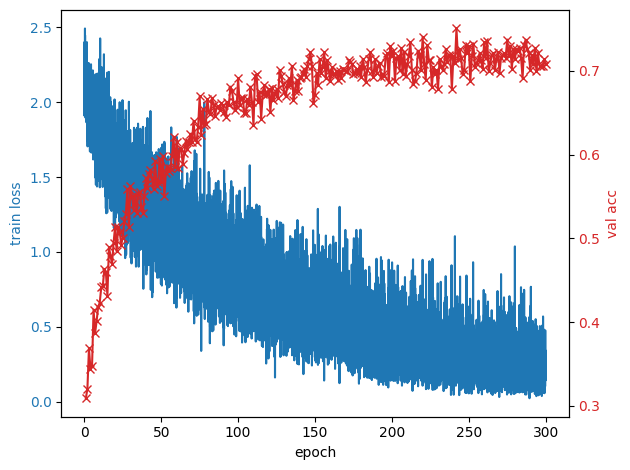

In [20]:
len_train_loss = len(train_loss_lst)
len_val_acc = len(val_acc_lst)
multi_times = len_train_loss // len_val_acc

print('========================= LEARNING CURVE =======================')
learning_curve(train_loss_lst, val_acc_lst, num_epochs, multi_times, smooth_factor=3)

### 模型测试

对于测试，我们可以采用跟验证阶段相同的代码，不过 dataloader 更改为 <code>test_loader</code>，并且不需要进行梯度回传。

### 任务 5（30 Points）
请自行调节模型训练的超参数、优化器等，使得模型在测试集上的准确率尽可能高。

分段给分（计分时准确率四舍五入保留到小数点后2位，例如0.623计为0.62）：

| Baseline  | Accuracy        | Score  |
| :---:     |    :----:       |  :---: |
| Vallina   | \[0.45, 0.63\]  |   15   |
| Simple    | (0.63, 0.70\]   |   18   |
| Medium    | (0.70, 0.77\]   |   20   |
| Hard      | (0.77, 0.83\]   |   25   |
| Strong    | (0.83, 1.00\]   |   30   |

In [21]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(test_loader, desc='Test', mininterval=1.0):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {:.4f} %'.format(len(test_dataset), 100 * correct / total))   

Test: 100%|██████████| 38/38 [00:09<00:00,  4.00it/s]

Accuracy of the network on the 1211 test images: 74.8968 %


#### **结果可视化**

In [22]:
# 选择测试集的一个子集进行可视化
num_images_to_show = 24

newClass = classes

24it [00:04,  5.85it/s]


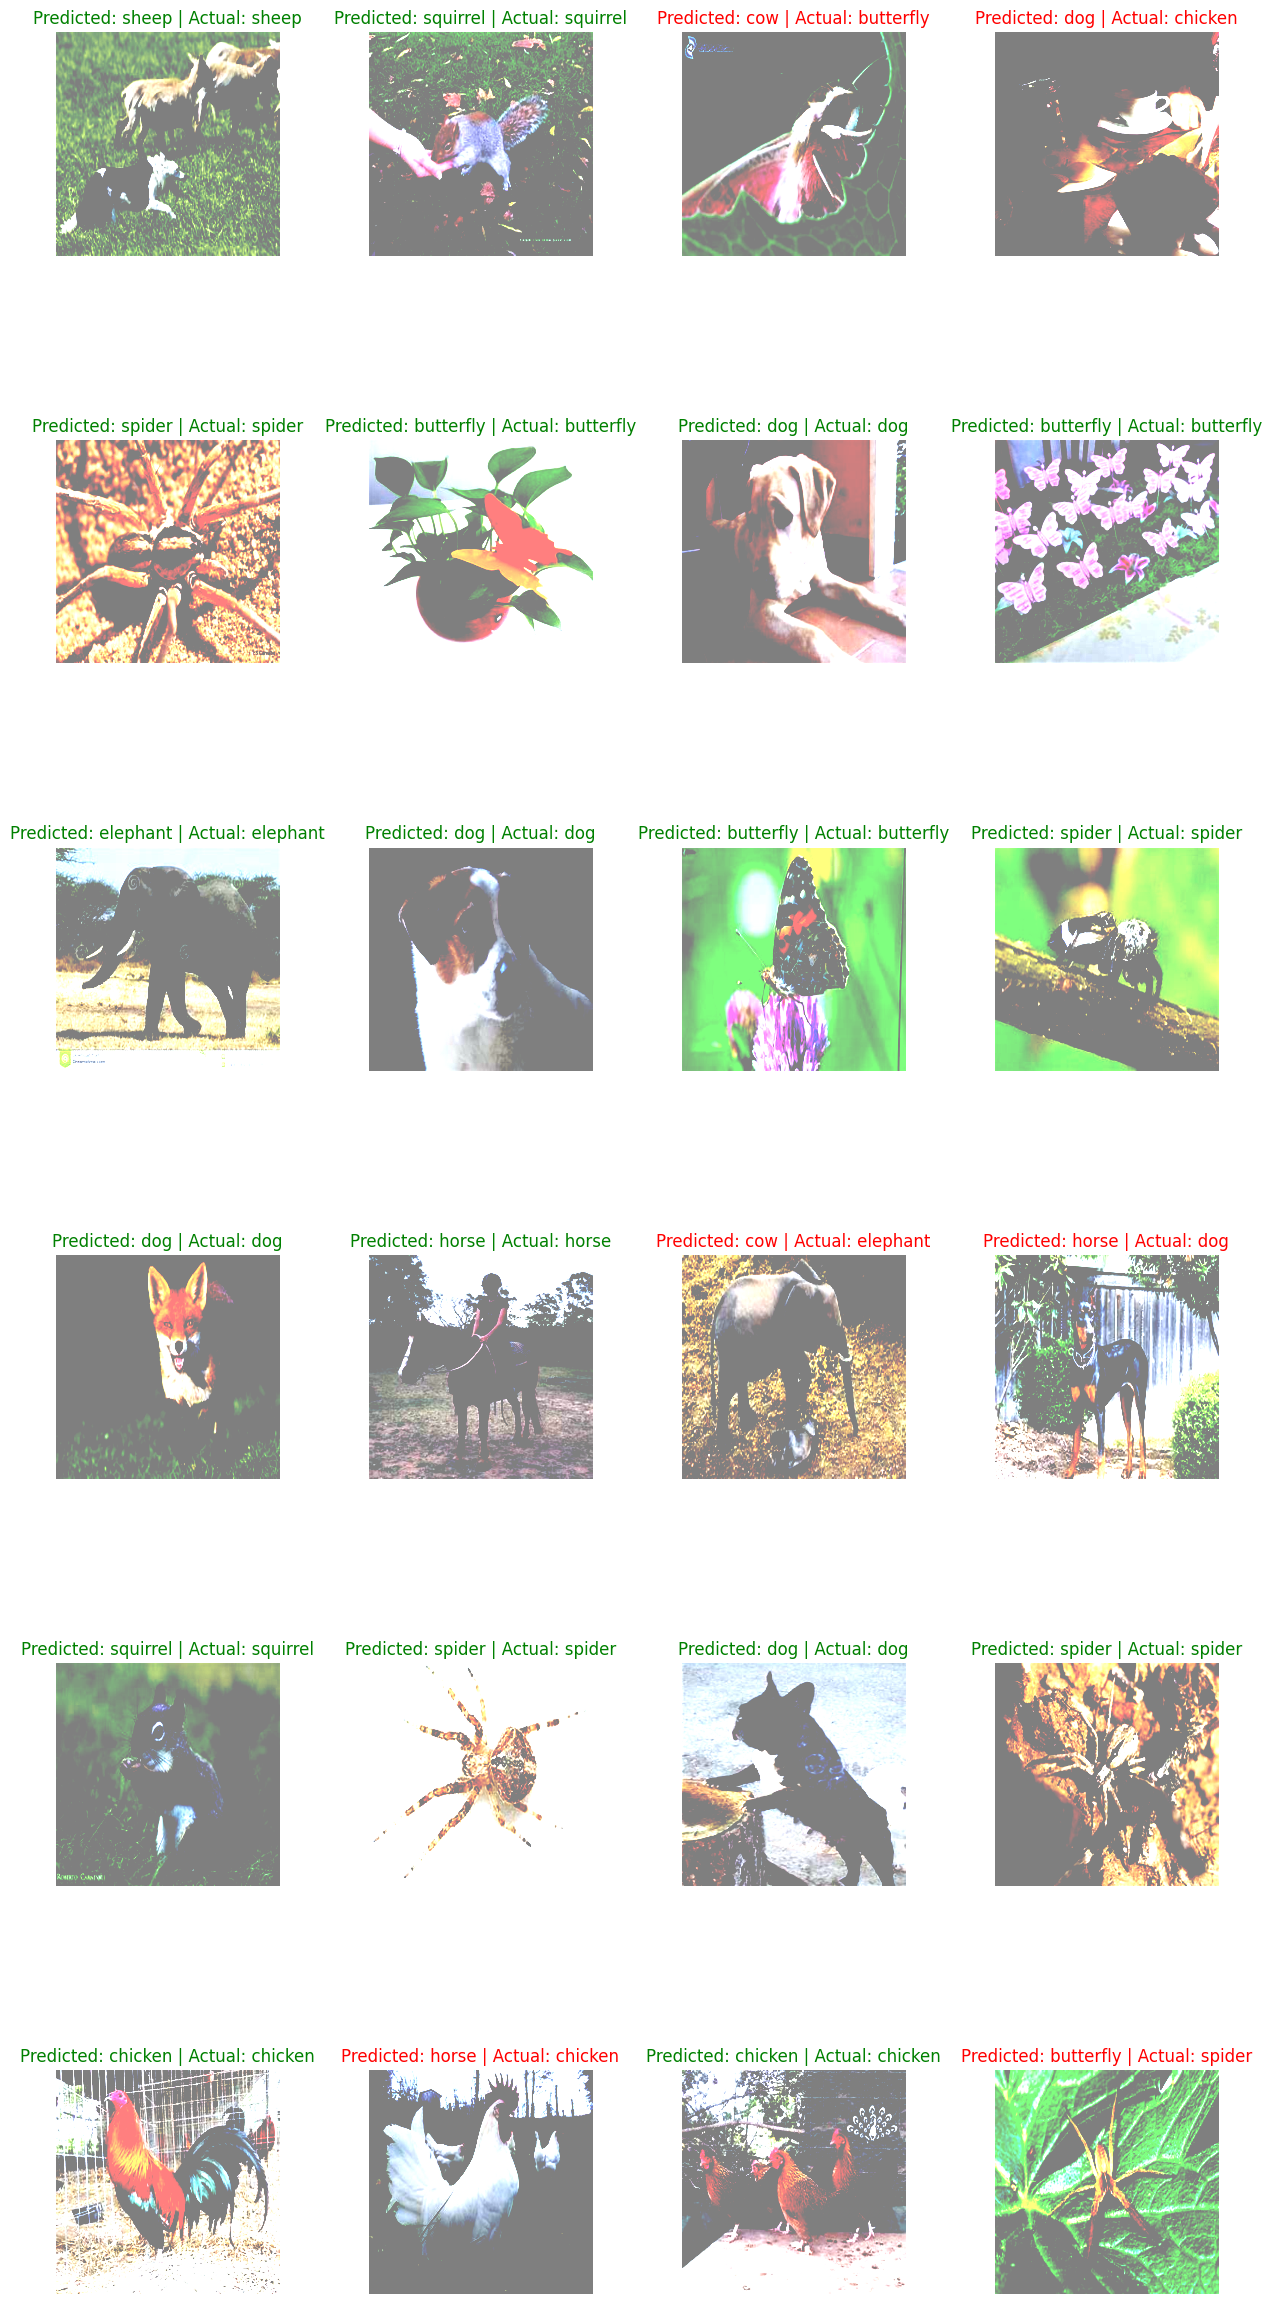

In [23]:
# Make predictions and plot images with predicted labels
plt.figure(figsize=(15, 30))
for i, (image, label) in tqdm(enumerate(test_loader, 1)):
    if i > 24:
        break
        
    with torch.no_grad():
        images = image.to(device)
        labels = label.to(device)
        output =  model(images)
        _, predicted = torch.max(output.data, 1)
        
        plt.subplot(6, 4, i)
        
        # Ensure pixel values are in the [0, 1] range
        image = torch.clamp(image, 0, 1)
        plt.imshow((image[0] * 0.5 + 0.5).permute(1, 2, 0))
        if(newClass[predicted[0]]==newClass[label[0]]):
            plt.title(f'Predicted: {newClass[predicted[0]]} | Actual: {newClass[label[0]]}',color="green")
        else:
            plt.title(f'Predicted: {newClass[predicted[0]]} | Actual: {newClass[label[0]]}',color="red")
       
        plt.axis('off')
    
        if i > num_images_to_show:
            break

plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.show()

#### **模型保存**

In [24]:
torch.save(model.state_dict(), "/kaggle/working/resnet_34.pth")

#### **模型下载**
保存好模型后需要大家从kaggle下载到本地，并提交。

下载模型的操作如下：

1. 首先在右侧Output下找到路径”/kaggle/working“，并刷新（不然，模型参数可能是之前保存的旧值）
<div style="text-align:center;">
    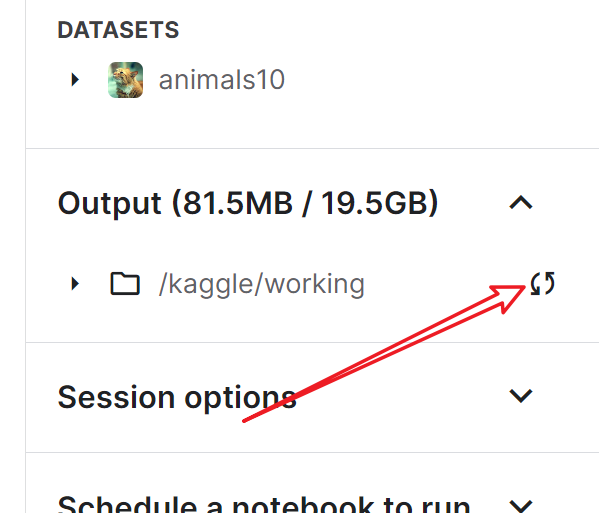
</div>
2. 然后在”/kaggle/working“目录下找到文件"resnet_34.pth"并下载到本地：
<div style="text-align:center;">
    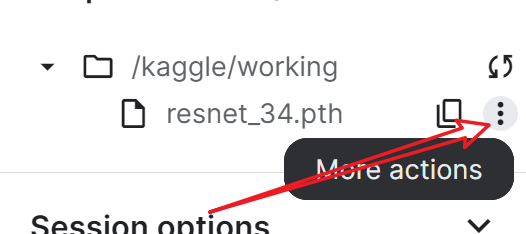
</div>